In [1]:
# Modelo YOLO Version 3 para detección de objetos (celdas de sangre)
# Basado en el repositorio de Manuel Garcia UEM Junio 2025

#1. Reproducibilidad total

import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Semilla global fijada en {SEED}")

Semilla global fijada en 42


In [2]:
# Modelo YOLO Version 3 para detección de objetos (celdas de sangre)
# Basado en el repositorio de Manuel Garcia UEM Junio 2025

# Ruta al repositorio 
# C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/

# Ruta al fichero de configuracion yolov3.cfg
#C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config

# Ruta a los pesos preentrenados yolov3.weights
# C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/weights/

# Importamos librerias

import torch
import torch.nn as nn
import sys
import os
import numpy as np 

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from sklearn.model_selection import train_test_split

import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm 

print("Liberias importadas correctamente")

#from yolov3_model_setup_V2_genie_OK import model, device  # Debe devolver el modelo ya adaptado y en el device
#from yolov3_dataset_setup_V4_genie_OK import BloodCellDataset, train_transforms, val_test_transforms, YOLO_INPUT_SIZE
#from yolov3_IOU_loss_function_V2_genie_OK import YOLOv3Loss


Liberias importadas correctamente


In [3]:
# Verificamos que PyTorch está instalado y la versión
print(f"Versión de PyTorch: {torch.__version__}")

# Verificamos que NumPy está instalado y la versión
print(f"Versión de NumPy: {np.__version__}")

# Verificamos que sys está instalado y la versión
print(f"Versión de sys: {sys.version}")
# Verificamos que os está instalado y la versión
print(f"Versión de os: {os.name}")
# Verificamos que la GPU está disponible (si es que se va a usar)
if torch.cuda.is_available():
    print("GPU disponible para PyTorch.")
    print(f"Dispositivo actual: {torch.cuda.get_device_name(0)}")
else:
    print("No se detecta GPU, se usará la CPU para el entrenamiento.")


Versión de PyTorch: 2.3.1
Versión de NumPy: 1.26.4
Versión de sys: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Versión de os: nt
No se detecta GPU, se usará la CPU para el entrenamiento.


In [4]:
# Configuración de rutas
# Ruta donde hemos clonado el repositorio de Erik Lindernoren.
YOLOV3_REPO_PATH = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/'
YOLOV3_MODELS_PATH = os.path.join(YOLOV3_REPO_PATH, 'pytorchyolo')
print(f"Ruta del repositorio YOLOv3: {YOLOV3_REPO_PATH}")
print(f"Ruta de los modelos YOLOv3: {YOLOV3_MODELS_PATH}")

# Rutas de Archivos Específicos
# Archivo de configuracion yolov3.cfg
CONFIG_PATH = os.path.join(YOLOV3_REPO_PATH, 'config', 'yolov3.cfg')
CONFIG_PATH = CONFIG_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac
print(f"Ruta del archivo de configuración YOLOv3: {CONFIG_PATH}")

# Archivo de pesos .weights descargado de https://github.com/patrick013/Object-Detection---Yolov3.git
WEIGHTS_PATH = os.path.join(YOLOV3_REPO_PATH, 'yolov3.weights')
WEIGHTS_PATH = WEIGHTS_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac
print(f"Ruta del archivo de pesos YOLOv3: {WEIGHTS_PATH}")

# Añadimos esta ruta al PYTHONPATH para que Python pueda encontrar los módulos.
sys.path.append(YOLOV3_REPO_PATH)
sys.path.append(YOLOV3_MODELS_PATH)
print(f"Rutas añadidas al PYTHONPATH: {YOLOV3_REPO_PATH} y {YOLOV3_MODELS_PATH}")

# Importamos las clases necesarias del repositorio.
# Darknet y YOLOLayer son las clases principales del modelo.
from models import Darknet, YOLOLayer 

# Detección del Dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Trabajando en el dispositivo: {device}")

Ruta del repositorio YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/
Ruta de los modelos YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/pytorchyolo
Ruta del archivo de configuración YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config/yolov3.cfg
Ruta del archivo de pesos YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/yolov3.weights
Rutas añadidas al PYTHONPATH: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/ y C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/pytorchyolo
Trabajando en el dispositivo: cpu


In [5]:
# Definicion del modelo
    
# Parámetros Generales
# Número de clases del dataset BCCD (Glóbulos Rojos, Glóbulos Blancos, Plaquetas).
NUM_CLASSES_YOUR_DATASET = 3
# Tamaño de la imagen de entrada para el modelo YOLOv3 (típicamente 416x416 o 608x608).
IMG_SIZE = 416 

# Definimos los anchor masks para tus 3 clases (placeholder hasta definir los adecuados con KMeans)
# YOLOv3 usa 9 anchor boxes en total, divididos en 3 grupos de 3 para cada escala.
# Estos son los INDICES de los anchors. Los valores reales los calculaamos con K-Means.
# Ejemplo: si los 9 anchors se ordenan de menor a mayor área, los grandes (indices 6,7,8) van a la escala 13x13.
#Anchor Boxes Calculadas (Formato para YOLOv3Loss): [[(227, 210), (179, 155), (124, 111)], [(105, 113), (104, 96), (80, 109)], [(112, 75), (87, 82), (39, 38)]]

DUMMY_ANCHORS_MASKS = [
    [(227, 210), (179, 155), (124, 111)],  # Anchors para la escala más grande (stride 32, detecta objetos grandes)
    [(105, 113), (104, 96), (80, 109)],    # Anchors para la escala media (stride 16, detecta objetos medianos)
    [(112, 75), (87, 82), (39, 38)]        # Anchors para la escala más pequeña (stride 8, detecta objetos pequeños)
]

ANCHORS = DUMMY_ANCHORS_MASKS

# Rutas de Archivos Específicos
# Archivo de configuracion yolov3.cfg
CONFIG_PATH = os.path.join(YOLOV3_REPO_PATH, 'config', 'yolov3.cfg')
CONFIG_PATH = CONFIG_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac

# Archivo de pesos .weights descargado de https://github.com/patrick013/Object-Detection---Yolov3.git
WEIGHTS_PATH = os.path.join(YOLOV3_REPO_PATH, 'yolov3.weights')
WEIGHTS_PATH = WEIGHTS_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac

# Detección del Dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Trabajando en el dispositivo: {device}")

# PASO 1: Instanciar el Modelo YOLOv3 (para 80 clases, usando el .cfg original)
# La clase Darknet de Erik Lindernoren construye el modelo leyendo el archivo yolov3.cfg.
# Esto crea el modelo con la arquitectura esperada por el archivo yolov3.weights.
print(f"Cargando la arquitectura del modelo desde: {CONFIG_PATH} (con classes=80)")
model = Darknet(CONFIG_PATH)
model.to(device) # Mueve el modelo al dispositivo (GPU/CPU)
print("Modelo YOLOv3 cargado correctamente en el dispositivo: ", device)

# PASO 2: Cargamos los Pesos Pre-entrenados
# El método load_darknet_weights() es el encargado de leer el archivo yolov3.weights.
try:
    print(f"Intentando cargar pesos pre-entrenados desde: {WEIGHTS_PATH}")
    model.load_darknet_weights(WEIGHTS_PATH)
    print("Pesos pre-entrenados cargados con éxito.")

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo de pesos en {WEIGHTS_PATH}.")
    print("El modelo se inicializará con pesos aleatorios (NO se usará transfer learning).")
    print("¡ADVERTENCIA! Entrenar desde cero con solo 300 imágenes será extremadamente difícil.")
except Exception as e:
    print(f"ERROR al cargar los pesos pre-entrenados: {e}")
    print("El modelo se inicializará con pesos aleatorios (NO se usará transfer learning).")
    print("¡ADVERTENCIA! Entrenar desde cero con solo 300 imágenes será extremadamente difícil.")

# ... (all your setup code above remains unchanged)

# PASO 3: Adaptacion del modelo para las 3 clases (FINE-TUNING EN MEMORIA)
print("\nAdaptando las capas de predicción a 3 clases...")

yolo_layer_index_in_model_yolo_layers = 0
for i, module_def in enumerate(model.module_defs):
    if module_def["type"] == "yolo":
        pred_conv_sequential_idx = i - 1
        pred_conv_layer_old = model.module_list[pred_conv_sequential_idx][0]
        yolo_layer_old_instance = model.yolo_layers[yolo_layer_index_in_model_yolo_layers]
        new_out_channels = len(yolo_layer_old_instance.anchors) * (5 + NUM_CLASSES_YOUR_DATASET)
        new_pred_conv_layer = nn.Conv2d(pred_conv_layer_old.in_channels, new_out_channels,
                                        kernel_size=pred_conv_layer_old.kernel_size,
                                        stride=pred_conv_layer_old.stride,
                                        padding=pred_conv_layer_old.padding,
                                        bias=True
                                        )
        model.module_list[pred_conv_sequential_idx] = nn.Sequential(new_pred_conv_layer)
        anchors_for_new_layer = yolo_layer_old_instance.anchors.tolist()
        stride_for_new_layer = yolo_layer_old_instance.stride
        new_yolo_layer = YOLOLayer(anchors_for_new_layer, NUM_CLASSES_YOUR_DATASET, new_coords=False)
        model.module_list[i] = nn.Sequential(new_yolo_layer)
        model.yolo_layers[yolo_layer_index_in_model_yolo_layers] = new_yolo_layer
        yolo_layer_index_in_model_yolo_layers += 1

print("Capas YOLOLayer y sus capas de predicción Conv2d adaptadas para 3 clases.")

# --- NUEVA SECCIÓN: CONGELAR TODAS LAS CAPAS, SOLO DESCONGELAR LAS ULTIMAS Conv2d DE PREDICCIÓN ---
print("\nConfigurando capas para Fine-Tuning (solo las capas Conv2d justo antes de cada YOLOLayer serán entrenables):")

# Congelar todos los parámetros por defecto
for param in model.parameters():
    param.requires_grad = False

# Solo las Conv2d antes de YOLOLayer quedan como entrenables
for i, module_def in enumerate(model.module_defs):
    if module_def["type"] == "yolo":
        pred_conv_sequential_idx = i - 1
        conv_seq = model.module_list[pred_conv_sequential_idx]
        # Buscar la capa Conv2d dentro del Sequential
        for layer in conv_seq:
            if isinstance(layer, nn.Conv2d):
                for param in layer.parameters():
                    param.requires_grad = True
                print(f"  Descongelada capa Conv2d antes del YOLOLayer en module_list[{i}]")

# --- Verificación de Capas Entrenables ---
print("\nVerificación de capas que se entrenarán ('requires_grad=True'):")
trainable_params_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal de parámetros entrenables: {trainable_params_count / 1e6:.2f} M")
print(f"Total de parámetros congelados: {(total_params - trainable_params_count) / 1e6:.2f} M")
print(f"Total de parámetros en el modelo: {total_params / 1e6:.2f} M")

# PASO 5: Prueba Final de la Pasada hacia Adelante (sanity check)
print("\nRealizando una pasada hacia adelante para verificar la configuración del modelo...")

model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    predictions = model(dummy_input)

print(f"\nShape de la salida del modelo después de cargar pesos y adaptar a {NUM_CLASSES_YOUR_DATASET} clases (en modo EVAL):")
print(f"  Escala 13x13: {predictions[0].shape} (Esperado: [N, 3*13*13, 5+C])")
print(f"  Escala 26x26: {predictions[1].shape} (Esperado: [N, 3*26*26, 5+C])")
print(f"  Escala 52x52: {predictions[2].shape} (Esperado: [N, 3*52*52, 5+C])")
print(f"¡Las dimensiones de salida para {NUM_CLASSES_YOUR_DATASET} clases son correctas en modo EVAL!\n")
print("\n--- ¡Fase de Configuración del Modelo YOLOv3 Completada Exitosamente! ---")


Trabajando en el dispositivo: cpu
Cargando la arquitectura del modelo desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config/yolov3.cfg (con classes=80)
Modelo YOLOv3 cargado correctamente en el dispositivo:  cpu
Intentando cargar pesos pre-entrenados desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/yolov3.weights
Pesos pre-entrenados cargados con éxito.

Adaptando las capas de predicción a 3 clases...
Capas YOLOLayer y sus capas de predicción Conv2d adaptadas para 3 clases.

Configurando capas para Fine-Tuning (solo las capas Conv2d justo antes de cada YOLOLayer serán entrenables):
  Descongelada capa Conv2d antes del YOLOLayer en module_list[82]
  Descongelada capa Conv2d antes del YOLOLayer en module_list[94]
  Descongelada capa Conv2d antes del YOLOLayer en module_list[106]

Verificación de capas que se entrenarán ('requires_grad=True'):
module_list.81.0.weight
module_list.81.0.bias
module_list.93.0.weight
module_list.93.0.bias
module_list.105.0.w

In [6]:
# Esta version es la que funciona mejor ya que ademas de preparar el dataset visualiza el resultado OJO OJO OJO
# Incluye la version definitiva incluyendo la funcion de visualizacion
# Ademas aplica un nivel razonable y seguro de DA ... hemos excluido las transformaciones Geométricas por considerar
# que pueden tener efecto distorsionante sobre el dataset (rotaciones, escalados, etc.)
# Se ha añadido la posibilidad de visualizar el dataset generado

In [7]:

# PASO 1: Definición de la clase BloodCellDataset
# Esta clase debe manejar la carga de imágenes y anotaciones, así como las transformaciones necesarias.
# Modificada para que filtre las bounding boxes degeneradas o inválidas.

class BloodCellDataset(Dataset):
    def __init__(self, data_root, annotations_df, image_size=(416, 416), transform=None):
        self.data_root = data_root
        self.image_folder = os.path.join(data_root, 'BCCD')
        self.image_size = image_size
        self.transform = transform
        
        self.class_name_to_id = {
            'RBC': 0, 'WBC': 1, 'Platelets': 2
        }
        self.class_id_to_name = {
            0: 'RBC', 1: 'WBC', 2: 'Platelets'
        }
        
        self.image_annotations = {}
        # Filtrar el DataFrame de anotaciones para eliminar filas con valores NaN en columnas clave
        annotations_df = annotations_df.dropna(subset=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'cell_type'])
        
        for filename, group in annotations_df.groupby('filename'):
            bboxes_pixel_list = []
            for idx, row in group.iterrows():
                cell_type = str(row['cell_type']) # Asegurarse de que sea string
                xmin = int(row['xmin'])
                xmax = int(row['xmax'])
                ymin = int(row['ymin'])
                ymax = int(row['ymax']) 
                
                class_id = self.class_name_to_id.get(cell_type)
                if class_id is None:
                    print(f"Advertencia: Tipo de célula desconocido '{cell_type}' en el archivo {filename}. Saltando anotación.")
                    continue

                # Asegurarse de que xmin < xmax y ymin < ymax antes de guardar
                if xmin >= xmax or ymin >= ymax:
                    # print(f"Advertencia: Bounding box degenerado o inválido en {filename}: ({xmin}, {ymin}, {xmax}, {ymax}). Saltando.")
                    continue # Saltar esta bbox inválida

                bboxes_pixel_list.append([xmin, ymin, xmax, ymax, class_id])
            
            # Solo añadir la imagen si tiene al menos una bbox válida
            if bboxes_pixel_list:
                self.image_annotations[filename] = bboxes_pixel_list
        
        self.image_files = list(self.image_annotations.keys())
        print(f"Dataset inicializado con {len(self.image_files)} imágenes.")
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            img_name = self.image_files[idx]
            img_path = os.path.join(self.image_folder, img_name)
        
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            original_h, original_w, _ = image.shape
            #print(f"DEBUG: Imagen original (H, W): ({original_h}, {original_w})")

            bboxes_pixel = self.image_annotations.get(img_name, [])
            #print(f"DEBUG: __getitem__ para {img_name}. Bboxes iniciales (píxeles): {len(bboxes_pixel)}")
            #if bboxes_pixel:
            #    print(f"DEBUG: Primer bbox pixel: {bboxes_pixel[0]}")
        
            # --- NORMALIZAR BBOXES A [0, 1] ANTES DE ALBUMENTATIONS ---
            # Albumentations espera bboxes normalizadas si format='albumentations'
            bboxes_normalized_initial = []
            class_labels = [] # class_labels se mantiene
            for bbox_px in bboxes_pixel:
                xmin_px, ymin_px, xmax_px, ymax_px, class_id = bbox_px
            
                # Normalizar las coordenadas a [0, 1] usando las dimensiones originales
                xmin_norm = xmin_px / original_w
                ymin_norm = ymin_px / original_h
                xmax_norm = xmax_px / original_w
                ymax_norm = ymax_px / original_h
            
                bboxes_normalized_initial.append([xmin_norm, ymin_norm, xmax_norm, ymax_norm])
                class_labels.append(class_id)
        
            #print(f"DEBUG: Bboxes normalizadas (iniciales): {len(bboxes_normalized_initial)}")
            #if bboxes_normalized_initial:
            #    print(f"DEBUG: Primer bbox normalizada (inicial): {bboxes_normalized_initial[0]}, clase: {class_labels[0]}")

            if self.transform:
                # Albumentations ahora recibe coordenadas normalizadas y las transformará.
                # Se espera que devuelva coordenadas normalizadas también.
                transformed = self.transform(image=image, bboxes=bboxes_normalized_initial, class_labels=class_labels)
                image = transformed['image']
                bboxes_transformed_raw = transformed['bboxes'] # Bboxes después de Albumentations (deberían estar normalizadas)
                class_labels = transformed['class_labels'] # Las etiquetas de clase se mantienen
            
            #print(f"DEBUG: Bboxes después de Albumentations (raw, deberían estar normalizadas): {len(bboxes_transformed_raw)}")
            #if bboxes_transformed_raw:
            #    print(f"DEBUG: Primer bbox después de Albumentations (raw, deberían estar normalizadas): {bboxes_transformed_raw[0]}")

            # --- ELIMINAR PASO DE RE-NORMALIZACIÓN HEURÍSTICA ---
            # Si Albumentations funciona como se espera con format='albumentations',
            # este paso ya no es necesario.
            bboxes = bboxes_transformed_raw # Usar las bboxes directamente de Albumentations
        
            #print(f"DEBUG: Bboxes finales antes de YOLO format: {len(bboxes)}")
            #if bboxes:
            #    print(f"DEBUG: Primer bbox final antes de YOLO format: {bboxes[0]}")
            # --- FIN ELIMINAR PASO ---


            # Si ToTensorV2 ya se aplicó, la imagen es un tensor. Si no, convertirla.
            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

            yolo_bboxes = []
            for i, bbox in enumerate(bboxes):
                x_min, y_min, x_max, y_max = bbox
            
                # Asegurar que las coordenadas estén dentro de [0, 1]
                x_min = max(0.0, min(1.0, x_min))
                y_min = max(0.0, min(1.0, y_min))
                x_max = max(0.0, min(1.0, x_max))
                y_max = max(0.0, min(1.0, y_max))

                center_x = (x_min + x_max) / 2
                width = x_max - x_min
                center_y = (y_min + y_max) / 2
                height = y_max - y_min
            
                # Este filtrado ya estaba, pero el error ocurría antes
                if width <= 0 or height <= 0:
                    print(f"DEBUG: Bbox filtrada por width/height <= 0: {bbox}")
                    continue # Saltar esta bbox inválida después de transformación

                yolo_bboxes.append([class_labels[i], center_x, center_y, width, height])
            
            #print(f"DEBUG: Bboxes finales en formato YOLO: {len(yolo_bboxes)}")
            #if yolo_bboxes:
            #    print(f"DEBUG: Primer bbox YOLO: {yolo_bboxes[0]}")

            if len(yolo_bboxes) == 0:
                # Devuelve un tensor vacío si no hay bboxes válidas
                yolo_bboxes = torch.zeros((0, 5), dtype=torch.float32)
            else:
                yolo_bboxes = torch.tensor(yolo_bboxes, dtype=torch.float32)
        
            return image, yolo_bboxes
        
        except Exception as e:
            print(f"Error en __getitem__ para idx {idx}: {e}")
            return torch.zeros((3, *self.image_size)), torch.zeros((0, 5))
        

# PASO 2: Definición de las transformaciones de Albumentations
# Define el tamaño de entrada de tu modelo YOLOv3 (416x416)

YOLO_INPUT_SIZE = (416, 416) 

# --- TRANSFORMACIONES DE ENTRENAMIENTO CON AUMENTACIÓN DE COLOR/APARIENCIA ---
train_transforms = A.Compose([
    # Redimensionamiento y Relleno
    A.LongestMaxSize(max_size=YOLO_INPUT_SIZE[0], p=1.0), 
    A.PadIfNeeded(min_height=YOLO_INPUT_SIZE[0], min_width=YOLO_INPUT_SIZE[1], border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    
    # Transformaciones de Color y Apariencia
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=3, p=0.1), # Asegúrate de que blur_limit es impar y no demasiado grande
    
    # Normalización y Conversión a Tensor
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(), 
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])) # El formato 'albumentations' espera y devuelve normalizado [0,1]

# Las transformaciones de validación/prueba se mantienen minimalistas
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=YOLO_INPUT_SIZE[0], p=1.0), 
    A.PadIfNeeded(min_height=YOLO_INPUT_SIZE[0], min_width=YOLO_INPUT_SIZE[1], border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])) 

# PASO 3: Definición de la función Collate_fn para el DataLoader
def collate_fn(batch):
    images = []
    bboxes = []
    for img, bbox_target in batch:
        images.append(img)
        bboxes.append(bbox_target) 
    images = torch.stack(images, 0)
    return images, bboxes

# PASO 4: Definición de la Lógica de División del Dataset y Creación de DataLoaders
# Modificada para que visualice las imágenes con las bounding boxes

if __name__ == '__main__':
    # RUTAS A LOS DATOS
    DATA_ROOT = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset'
    CSV_FILE = os.path.join(DATA_ROOT, 'annotations.csv') 
        
    # Parámetros de la división
    TEST_SPLIT_RATIO = 0.15    
    VAL_SPLIT_RATIO = 0.15     
    RANDOM_SEED = 42           

    BATCH_SIZE = 8
    NUM_WORKERS = 0 # Deja en 0 para depuración, luego puedes aumentarlo a 4-8

    # --- Cargar todas las anotaciones y obtener nombres de archivo únicos ---
    print(f"Cargando todas las anotaciones desde: {CSV_FILE}")
    full_df = pd.read_csv(CSV_FILE)
    
    # Obtener la lista de nombres de archivo únicos presentes en el CSV
    all_image_filenames = full_df['filename'].unique().tolist()
    print(f"Total de {len(all_image_filenames)} imágenes únicas encontradas en el CSV.")

    # --- Dividir los nombres de archivo en entrenamiento y test ---
    train_val_filenames, test_filenames = train_test_split(
        all_image_filenames, 
        test_size=TEST_SPLIT_RATIO, 
        random_state=RANDOM_SEED
    )
    
    train_filenames, val_filenames = train_test_split(
        train_val_filenames, 
        test_size=VAL_SPLIT_RATIO / (1 - TEST_SPLIT_RATIO), 
        random_state=RANDOM_SEED
    )

    print(f"Imágenes para entrenamiento: {len(train_filenames)}")
    print(f"Imágenes para validación: {len(val_filenames)}")
    print(f"Imágenes para prueba: {len(test_filenames)}")

    # --- Crear DataFrames de anotaciones para cada split ---
    train_df = full_df[full_df['filename'].isin(train_filenames)].copy()
    val_df = full_df[full_df['filename'].isin(val_filenames)].copy()
    test_df = full_df[full_df['filename'].isin(test_filenames)].copy()

    # --- Crear instancias del Dataset y DataLoader para cada split ---
    train_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=train_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=train_transforms
    )
    val_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=val_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=val_test_transforms 
    )
    test_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=test_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=val_test_transforms 
    )

    #train_dataloader = DataLoader(
    #    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)
    #val_dataloader = DataLoader(
    #    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)
    #test_dataloader = DataLoader(
    #    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)

    PIN_MEMORY = torch.cuda.is_available()  # Solo True si hay GPU

    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )
    
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )

    test_dataloader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )

    print("\nDataset y DataLoaders de entrenamiento, validación y prueba configurados exitosamente.")

    # --- Verificación de la carga de un lote de entrenamiento ---
    print("\nVerificando la carga de un lote de entrenamiento...")
    MAX_BATCHES_TO_CHECK = 10 
    found_image_with_boxes = False

    for batch_idx, (images, targets) in enumerate(train_dataloader):
        print(f"Tamaño del lote {batch_idx+1}: Imágenes: {images.shape}, Targets: {len(targets)}")
        
        # Buscar una imagen con cajas en el lote actual
        for img_idx in range(len(targets)):
            if targets[img_idx].numel() > 0: 
                print(f"--- Encontrada imagen con {targets[img_idx].shape[0]} cajas en el lote {batch_idx+1}, imagen {img_idx+1} ---")
                print(f"Ejemplo de target para esta imagen (clase, cx, cy, w, h normalizados):")
                print(targets[img_idx][0])
                
                # --- Lógica de visualización ---
                mean = torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1).to(images[img_idx].device)
                std = torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1).to(images[img_idx].device)
                
                img_display_rgb = (images[img_idx] * std + mean) * 255
                img_display_rgb = img_display_rgb.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                img_display_bgr = cv2.cvtColor(img_display_rgb, cv2.COLOR_RGB2BGR)
                
                img_h, img_w = img_display_bgr.shape[:2]
                
                CLASS_ID_TO_NAME_MAP = {0: 'RBC', 1: 'WBC', 2: 'Platelets'}
                CLASS_COLORS_MAP = {0: (0, 0, 255), 1: (0, 255, 0), 2: (255, 0, 0)} # BGR

                print("\nVisualizando la imagen con GT Boxes (presiona cualquier tecla para cerrar)...")
                for bbox_yolo in targets[img_idx].tolist():
                    class_id, cx, cy, w, h = bbox_yolo
                    
                    x_min_norm = cx - w/2
                    y_min_norm = cy - h/2
                    x_max_norm = cx + w/2
                    y_max_norm = cy + h/2

                    x_min_px = int(x_min_norm * img_w)
                    y_min_px = int(y_min_norm * img_h)
                    x_max_px = int(x_max_norm * img_w)
                    y_max_px = int(y_max_norm * img_h)

                    color = CLASS_COLORS_MAP.get(int(class_id), (255, 255, 255)) 
                    cv2.rectangle(img_display_bgr, (x_min_px, y_min_px), (x_max_px, y_max_px), color, 2)

                    label_text = f"{CLASS_ID_TO_NAME_MAP.get(int(class_id), 'Unknown')}"
                    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                    text_x = x_min_px
                    text_y = y_min_px - 5 if y_min_px - 5 > 5 else y_min_px + text_size[1] + 5
                    
                    cv2.rectangle(img_display_bgr, (text_x, text_y - text_size[1] - 5), 
                                (text_x + text_size[0] + 5, text_y + 5), color, -1)
                    cv2.putText(img_display_bgr, label_text, (text_x, text_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                cv2.imshow("Imagen con GT Boxes", img_display_bgr)
                cv2.waitKey(0) 
                cv2.destroyAllWindows()
                
                found_image_with_boxes = True
                break 
        
        if found_image_with_boxes or batch_idx + 1 >= MAX_BATCHES_TO_CHECK:
            break 

    if not found_image_with_boxes:
        print(f"\nNo se encontró ninguna imagen con bounding boxes en los primeros {MAX_BATCHES_TO_CHECK} lotes.")
        print("Esto podría deberse a que todas las imágenes mostradas no tenían bboxes o fueron filtradas.")
        print("Considera revisar:")
        print("1. El contenido de 'annotations.csv' para asegurar que hay bboxes válidas.")
        print("2. Los filtros en BloodCellDataset (xmin >= xmax, etc.).")
        print("3. Los parámetros de bbox en Albumentations (min_area, min_visibility).")
        print("4. Si RandomCrop está eliminando demasiadas bboxes si son pequeñas o están en los bordes.")

Cargando todas las anotaciones desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset\annotations.csv
Total de 364 imágenes únicas encontradas en el CSV.
Imágenes para entrenamiento: 254
Imágenes para validación: 55
Imágenes para prueba: 55
Dataset inicializado con 254 imágenes.
Dataset inicializado con 55 imágenes.
Dataset inicializado con 55 imágenes.

Dataset y DataLoaders de entrenamiento, validación y prueba configurados exitosamente.

Verificando la carga de un lote de entrenamiento...
Tamaño del lote 1: Imágenes: torch.Size([8, 3, 416, 416]), Targets: 8
--- Encontrada imagen con 8 cajas en el lote 1, imagen 1 ---
Ejemplo de target para esta imagen (clase, cx, cy, w, h normalizados):
tensor([0.0000, 0.8195, 0.3250, 0.1578, 0.1500])

Visualizando la imagen con GT Boxes (presiona cualquier tecla para cerrar)...


In [8]:
# IOU y Funcion de Perdida de YOLOV3

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError("box_format debe ser 'midpoint' o 'corners'")

    x1_inter = torch.max(box1_x1, box2_x1)
    y1_inter = torch.max(box1_y1, box2_y1)
    x2_inter = torch.min(box1_x2, box2_x2)
    y2_inter = torch.min(box1_y2, box2_y2)

    intersection = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    union = box1_area + box2_area - intersection + 1e-6
    iou = intersection / union
    return iou

class YOLOv3Loss(nn.Module):
    def __init__(self, anchors, num_classes, img_size=(416, 416),
                lambda_coord=1.0, lambda_noobj=1.0, lambda_obj=1.0, lambda_class=1.0,
                ignore_iou_threshold=0.5, device=None):
        super().__init__()
        self.anchors = anchors
        self.num_classes = num_classes
        self.img_size = img_size
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class
        self.ignore_iou_threshold = ignore_iou_threshold

        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0]))
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, predictions, targets):
        obj_loss = 0
        noobj_loss = 0
        box_loss = 0
        class_loss = 0

        # Convert anchors to tensor only once, on correct device
        anchors_tensor = [torch.tensor(a, dtype=torch.float32, device=self.device) for a in self.anchors]

        for scale_idx, prediction in enumerate(predictions):
            #print(f"DEBUG: Shape prediction[{scale_idx}]: {prediction.shape}")
            #if prediction.dim() != 4:
            #    print(f"WARNING: prediction[{scale_idx}] tiene {prediction.dim()} dimensiones: {prediction.shape}")
            #continue  # o lanza una excepción explicativa
            # ... sigue con permute y reshape ...
            # prediction: (N, 3*(5+C), H, W)
            prediction = prediction.permute(0, 2, 3, 1).reshape(
                prediction.shape[0], prediction.shape[2], prediction.shape[3], 3, self.num_classes + 5
            )

            pred_x_y = prediction[..., 0:2]
            pred_w_h = prediction[..., 2:4]
            pred_obj = prediction[..., 4:5]
            pred_class = prediction[..., 5:]

            N, grid_h, grid_w, num_anchors, _ = prediction.shape

            anchors_current_scale = anchors_tensor[scale_idx].reshape(1, 1, 1, num_anchors, 2)

            # Inicializar todo en el device correcto
            target_obj_mask = torch.zeros((N, grid_h, grid_w, num_anchors), dtype=torch.float32, device=self.device)
            target_noobj_mask = torch.ones((N, grid_h, grid_w, num_anchors), dtype=torch.float32, device=self.device)
            tx = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            ty = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            tw = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            th = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            target_class_one_hot = torch.zeros((N, grid_h, grid_w, num_anchors, self.num_classes), dtype=torch.float32, device=self.device)

            # Vectorizar asignación de anchors
            if targets.numel() > 0:
                # targets: (num_true_boxes_in_batch, 6)
                img_ids = targets[:, 0].long()
                class_ids = targets[:, 1].long()
                x_gt_norm = targets[:, 2]
                y_gt_norm = targets[:, 3]
                w_gt_norm = targets[:, 4]
                h_gt_norm = targets[:, 5]

                x_center_grid = x_gt_norm * grid_w
                y_center_grid = y_gt_norm * grid_h
                cell_x = x_center_grid.long()
                cell_y = y_center_grid.long()

                # Filtrar targets fuera de grid
                grid_mask = (cell_x >= 0) & (cell_x < grid_w) & (cell_y >= 0) & (cell_y < grid_h) & (img_ids >= 0) & (img_ids < N)
                img_ids = img_ids[grid_mask]
                class_ids = class_ids[grid_mask]
                cell_x = cell_x[grid_mask]
                cell_y = cell_y[grid_mask]
                x_center_grid = x_center_grid[grid_mask]
                y_center_grid = y_center_grid[grid_mask]
                w_gt_norm = w_gt_norm[grid_mask]
                h_gt_norm = h_gt_norm[grid_mask]

                # Anchors assignment (vectorized)
                w_gt_pix = w_gt_norm * self.img_size[0]
                h_gt_pix = h_gt_norm * self.img_size[1]
                gt_box_dims = torch.stack([
                    torch.zeros_like(w_gt_pix), torch.zeros_like(h_gt_pix), w_gt_pix, h_gt_pix
                ], dim=1)  # (num_boxes, 4)

                anchor_boxes_for_iou = torch.zeros((num_anchors, 4), device=self.device)
                anchor_boxes_for_iou[:, 2] = anchors_current_scale[0,0,0,:,0]
                anchor_boxes_for_iou[:, 3] = anchors_current_scale[0,0,0,:,1]

                # Expand gt_box_dims for broadcasting
                gt_box_dims_exp = gt_box_dims.unsqueeze(1).expand(-1, num_anchors, 4)  # (num_boxes, num_anchors, 4)
                anchors_exp = anchor_boxes_for_iou.unsqueeze(0).expand(gt_box_dims.size(0), -1, 4)  # (num_boxes, num_anchors, 4)

                ious = intersection_over_union(gt_box_dims_exp, anchors_exp, box_format="corners").squeeze(-1)  # (num_boxes, num_anchors)
                best_iou_anchor_idx = torch.argmax(ious, dim=1)  # (num_boxes,)

                for idx in range(img_ids.shape[0]):
                    i = img_ids[idx]
                    c = class_ids[idx]
                    cx = cell_x[idx]
                    cy = cell_y[idx]
                    best_anchor = best_iou_anchor_idx[idx]
                    # Masks
                    target_obj_mask[i, cy, cx, best_anchor] = 1.0
                    target_noobj_mask[i, cy, cx, best_anchor] = 0.0
                    # Coordinates
                    tx[i, cy, cx, best_anchor] = x_center_grid[idx] - cx
                    ty[i, cy, cx, best_anchor] = y_center_grid[idx] - cy
                    tw[i, cy, cx, best_anchor] = torch.log(w_gt_pix[idx] / anchors_current_scale[0,0,0,best_anchor,0] + 1e-16)
                    th[i, cy, cx, best_anchor] = torch.log(h_gt_pix[idx] / anchors_current_scale[0,0,0,best_anchor,1] + 1e-16)
                    # Class
                    target_class_one_hot[i, cy, cx, best_anchor, c] = 1.0
                    # Ignore anchors with high IoU
                    for anchor_idx_other in range(num_anchors):
                        if anchor_idx_other == best_anchor:
                            continue
                        if ious[idx, anchor_idx_other] > self.ignore_iou_threshold:
                            target_noobj_mask[i, cy, cx, anchor_idx_other] = 0.0

            loss_x = self.bce(pred_x_y[..., 0][target_obj_mask.bool()], tx[target_obj_mask.bool()])
            loss_y = self.bce(pred_x_y[..., 1][target_obj_mask.bool()], ty[target_obj_mask.bool()])
            loss_w = self.mse(pred_w_h[..., 0][target_obj_mask.bool()], tw[target_obj_mask.bool()])
            loss_h = self.mse(pred_w_h[..., 1][target_obj_mask.bool()], th[target_obj_mask.bool()])
            box_loss += (loss_x + loss_y + loss_w + loss_h)

            loss_obj = self.bce(pred_obj[target_obj_mask.bool()], target_obj_mask[target_obj_mask.bool()].float().unsqueeze(-1))
            loss_noobj = self.bce(pred_obj[target_noobj_mask.bool()], target_noobj_mask[target_noobj_mask.bool()].float().unsqueeze(-1))
            obj_loss += loss_obj
            noobj_loss += loss_noobj

            loss_class = self.bce(pred_class[target_obj_mask.bool()], target_class_one_hot[target_obj_mask.bool()])
            class_loss += loss_class

        total_loss = (
            self.lambda_coord * box_loss
            + self.lambda_obj * obj_loss
            + self.lambda_noobj * noobj_loss
            + self.lambda_class * class_loss
        )
        return total_loss, {"box_loss": box_loss, "obj_loss": obj_loss, "noobj_loss": noobj_loss, "class_loss": class_loss}

In [9]:
# Adaptación de las predicciones para la función de pérdida
# Esta función adapta las predicciones del modelo para que coincidan con el formato esperado por la función de pérdida.

def adapt_predictions_for_loss(predictions, num_classes):
    adapted = []
    for idx, p in enumerate(predictions):
        if p.dim() != 5:
            print(f"WARNING: predictions[{idx}] tiene {p.dim()} dimensiones y shape {p.shape} (esperado: 5D). Se ignora este tensor.")
            continue  # salta este tensor
        B, A, H, W, C = p.shape  # C=5+num_classes
        p = p.permute(0, 1, 4, 2, 3).contiguous()  # [B, A, 5+C, H, W]
        p = p.view(B, -1, H, W)  # [B, A*(5+C), H, W]
        adapted.append(p)
    return adapted

In [10]:
# Función de decodificación de predicciones YOLOv3
# Función de decodificación de predicciones YOLOv3

def yolo_decode_outputs(outputs, anchors, num_classes, img_size, conf_thres=0.3, iou_thres=0.5, device='cpu', debug=False):
    """
    Decodifica las predicciones de YOLOv3 (PyTorch) y aplica NMS.
    Adapta automáticamente la forma del tensor (aplanado o no).
    """
    from torchvision.ops import nms
    batch_size = outputs[0].shape[0]
    final_preds = [[] for _ in range(batch_size)]
    for scale_idx, output in enumerate(outputs):
        if debug:
            print(f"DEBUG: outputs[{scale_idx}].shape = {output.shape}")
        anchor_set = torch.tensor(anchors[scale_idx], dtype=torch.float32, device=device)
        nA = len(anchors[scale_idx])
        N = output.shape[1] if output.dim() == 3 else None
        # Deducimos grid_size
        if output.dim() == 3:
            # Caso [batch, N, 5+C] (aplanado)
            grid_size = int((output.shape[1] // nA) ** 0.5)
            if output.shape[1] != nA * grid_size * grid_size:
                raise ValueError(f"Shape inesperado: {output.shape}")
            output = output.view(batch_size, nA, grid_size, grid_size, 5 + num_classes)
            if debug:
                print(f" -> reshape a [{batch_size},{nA},{grid_size},{grid_size},{5+num_classes}]")
        elif output.dim() == 5:
            # Caso ya en [batch, nA, grid, grid, 5+C]
            grid_size = output.shape[2]
            # No hace falta reshape
        else:
            raise ValueError(f"Shape no soportado: {output.shape}")
        output = output.cpu()  # para facilitar
        for b in range(batch_size):
            pred = output[b]  # [nA, grid, grid, 5+C]
            pred = pred.permute(0, 2, 3, 1).contiguous().view(-1, 5 + num_classes)  # [nA*grid*grid, 5+C]
            # Sigmoid para cx, cy, conf, clases
            pred_boxes = pred[:, :4]
            pred_obj = pred[:, 4].sigmoid()
            pred_cls = pred[:, 5:].sigmoid()
            pred[:, 4:] = torch.cat([pred_obj.unsqueeze(1), pred_cls], 1)
            # Filtra por confianza mínima
            mask = pred_obj > conf_thres
            pred = pred[mask]
            if pred.shape[0] == 0:
                continue
            # Encuentra clase más probable y conf
            class_confs, class_ids = pred[:, 5:].max(1)
            scores = pred[:, 4] * class_confs
            cx, cy, w, h = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
            # Las coord. suelen estar normalizadas a [0,1]
            x1 = cx - w/2
            y1 = cy - h/2
            x2 = cx + w/2
            y2 = cy + h/2
            boxes_xyxy = torch.stack([x1, y1, x2, y2], 1)
            keep = nms(boxes_xyxy, scores, iou_thres)
            for idx in keep:
                final_preds[b].append([
                    int(class_ids[idx].item()),
                    cx[idx].item(),
                    cy[idx].item(),
                    w[idx].item(),
                    h[idx].item(),
                    scores[idx].item()
                ])
    final_preds = [np.array(p) if len(p) else np.zeros((0,6)) for p in final_preds]
    return final_preds



In [11]:
# ========== 1. Anchors personalizados ==========
ANCHORS = [
    [(227, 210), (179, 155), (124, 111)],  # 13x13
    [(105, 113), (104, 96), (80, 109)],    # 26x26
    [(112, 75), (87, 82), (39, 38)]        # 52x52
]

In [12]:
# Funcion de calculo de metricas de evaluación IoU, Precisión, Recall y mAP

def calculate_iou(box1, box2):
    # box: (cx, cy, w, h) formato normalizado [0,1]
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area + 1e-12
    return inter_area / union

In [13]:
def simple_epoch_metrics(model, loader, device, anchors=ANCHORS, num_classes=3, iou_threshold=0.5, conf_threshold=0.3):
    model.eval()
    total_iou = []
    tp, fp, fn = 0, 0, 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            # 1. Obtén predicciones del modelo
            outputs = model(images)
            # 2. Decodifica y filtra predicciones
            pred_boxes = yolo_decode_outputs(outputs, anchors, num_classes, img_size=416, conf_thres=conf_threshold, iou_thres=iou_threshold, device=device)
            # 3. Para cada imagen del batch:
            for i in range(len(targets)):
                gt_boxes = targets[i].cpu().numpy()
                preds_img = pred_boxes[i]  # [N_pred, 6] (class, cx, cy, w, h, conf)
                matched_gt = set()
                # Haz matching pred↔gt y calcula IoU, TP, FP, FN igual que antes
                for pb in preds_img:
                    best_iou = 0
                    best_idx = -1
                    for idx, gb in enumerate(gt_boxes):
                        if int(pb[0]) != int(gb[0]):
                            continue
                        iou = calculate_iou(pb[1:5], gb[1:5])
                        if iou > best_iou:
                            best_iou = iou
                            best_idx = idx
                    total_iou.append(best_iou)
                    if best_iou >= iou_threshold and best_idx not in matched_gt:
                        tp += 1
                        matched_gt.add(best_idx)
                    else:
                        fp += 1
                fn += len(gt_boxes) - len(matched_gt)
    mean_iou = np.mean(total_iou) if total_iou else 0.0
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    mAP = mean_iou  # Placeholder mAP
    print(f"IoU: {mean_iou:.4f} - Precisión: {precision:.4f} - Recall: {recall:.4f}")
    return mean_iou, precision, recall, mAP

In [14]:
# Entrenamiento del modelo YOLO Version 3

# ========== 1. Anchors personalizados ==========
ANCHORS = [
    [(227, 210), (179, 155), (124, 111)],  # 13x13
    [(105, 113), (104, 96), (80, 109)],    # 26x26
    [(112, 75), (87, 82), (39, 38)]        # 52x52
]

# ========== 2. Paths y parámetros ==========

DATA_ROOT = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset'
CSV_FILE = os.path.join(DATA_ROOT, 'annotations.csv')
BATCH_SIZE = 4
NUM_WORKERS = 0  # Ajusta según tu máquina
NUM_CLASSES = 3
IMG_SIZE = YOLO_INPUT_SIZE
EPOCHS = 50
LR = 1e-4
WEIGHT_DECAY = 1e-4

# ========== 3. Crear datasets y dataloaders ==========

full_df = pd.read_csv(CSV_FILE)
all_image_filenames = full_df['filename'].unique().tolist()
train_val_filenames, test_filenames = train_test_split(
    all_image_filenames, test_size=0.15, random_state=42)
train_filenames, val_filenames = train_test_split(
    train_val_filenames, test_size=0.15/(1-0.15), random_state=42)

train_df = full_df[full_df['filename'].isin(train_filenames)].copy()
val_df = full_df[full_df['filename'].isin(val_filenames)].copy()
test_df = full_df[full_df['filename'].isin(test_filenames)].copy()

train_dataset = BloodCellDataset(DATA_ROOT, train_df, image_size=IMG_SIZE, transform=train_transforms)
val_dataset = BloodCellDataset(DATA_ROOT, val_df, image_size=IMG_SIZE, transform=val_test_transforms)
test_dataset = BloodCellDataset(DATA_ROOT, test_df, image_size=IMG_SIZE, transform=val_test_transforms)

print(f"Total imágenes de entrenamiento: {len(train_dataset)}")
print(f"Total imágenes de validación: {len(val_dataset)}")
print(f"Total imágenes de prueba: {len(test_dataset)}")

def collate_fn(batch):
    images, bboxes = [], []
    for img, bbox_target in batch:
        images.append(img)
        bboxes.append(bbox_target)
    images = torch.stack(images, 0)
    return images, bboxes

PIN_MEMORY = torch.cuda.is_available()  # Solo True si hay GPU

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)

print("\nDataLoaders de entrenamiento, validación y prueba configurados exitosamente.")

# ========== 4. Pérdida y optimizador ==========
loss_fn = YOLOv3Loss(
    anchors=ANCHORS,
    num_classes=NUM_CLASSES,
    img_size=IMG_SIZE,
    lambda_coord=1.0,
    lambda_noobj=1.0,
    lambda_obj=1.0,
    lambda_class=1.0,
    ignore_iou_threshold=0.5,
    device=device
).to(device)

# Solo parámetros entrenables (recuerda: solo los heads)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)

# ========== 5. Training Loop ==========
from tqdm import tqdm

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss, box_loss, obj_loss, noobj_loss, class_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    for images, targets in tqdm(loader, desc="Entrenando"):
        if images.shape[0] == 0:
            print("Batch vacío saltado (entrenamiento)")
            continue  # Salta este batch vacío
        images = images.to(device)
        all_targets = []
        for batch_idx, t in enumerate(targets):
            if t.numel() > 0:
                img_idx_col = torch.full((t.shape[0], 1), batch_idx, dtype=torch.float32, device=device)
                all_targets.append(torch.cat([img_idx_col, t.to(device)], dim=1))
        if len(all_targets) > 0:
            all_targets = torch.cat(all_targets, dim=0)
        else:
            all_targets = torch.zeros((0, 6), dtype=torch.float32, device=device)
        optimizer.zero_grad()
        if all_targets.numel() == 0:
            print("Batch de imágenes sin ningún target: saltado.")
            continue
        predictions = model(images)
        #print([p.shape for p in predictions])
        predictions = adapt_predictions_for_loss(predictions, num_classes=NUM_CLASSES)
        loss, components = loss_fn(predictions, all_targets)
        loss.backward()
        optimizer.step()
        #running_loss += loss.item()
        #box_loss += components['box_loss'].item()
        #obj_loss += components['obj_loss'].item()
        #noobj_loss += components['noobj_loss'].item()
        #class_loss += components['class_loss'].item()
        running_loss += float(loss)
        box_loss += float(components['box_loss'])
        obj_loss += float(components['obj_loss'])
        noobj_loss += float(components['noobj_loss'])
        class_loss += float(components['class_loss'])
    n = len(loader)
    if n == 0:
        return 0, 0, 0, 0, 0
    return (running_loss/n, box_loss/n, obj_loss/n, noobj_loss/n, class_loss/n)

@torch.no_grad()
def validate_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss, box_loss, obj_loss, noobj_loss, class_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    for images, targets in tqdm(loader, desc="Validando"):
        if images.shape[0] == 0:
            print("Batch vacío saltado (validacion)")
            continue  # Salta este batch vacío
        images = images.to(device)
        all_targets = []
        for batch_idx, t in enumerate(targets):
            if t.numel() > 0:
                img_idx_col = torch.full((t.shape[0], 1), batch_idx, dtype=torch.float32, device=device)
                all_targets.append(torch.cat([img_idx_col, t.to(device)], dim=1))
        if len(all_targets) > 0:
            all_targets = torch.cat(all_targets, dim=0)
        else:
            all_targets = torch.zeros((0, 6), dtype=torch.float32, device=device)
        optimizer.zero_grad()
        if all_targets.numel() == 0:
            print("Batch de imágenes sin ningún target: saltado.")
            continue
        predictions = model(images)
        #print([p.shape for p in predictions])
        predictions = adapt_predictions_for_loss(predictions, num_classes=NUM_CLASSES)
        loss, components = loss_fn(predictions, all_targets)
        #loss.backward()
        #optimizer.step()
        #running_loss += loss.item()
        #box_loss += components['box_loss'].item()
        #obj_loss += components['obj_loss'].item()
        #noobj_loss += components['noobj_loss'].item()
        #class_loss += components['class_loss'].item()
        running_loss += float(loss)
        box_loss += float(components['box_loss'])
        obj_loss += float(components['obj_loss'])
        noobj_loss += float(components['noobj_loss'])
        class_loss += float(components['class_loss'])
    n = len(loader)
    if n == 0:
        return 0, 0, 0, 0, 0
    return (running_loss/n, box_loss/n, obj_loss/n, noobj_loss/n, class_loss/n)

# ========== 6. Loop principal de entrenamiento ==========

patience = 10  # Epochs sin mejora antes de parar
epochs_no_improve = 0
best_val_loss = float('inf')
writer = SummaryWriter(log_dir='runs/yolov3_bloodcell')
writer = SummaryWriter(log_dir="runs/yolov3_metrics")

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Época {epoch}/{EPOCHS} ===")
    t_loss, t_box, t_obj, t_noobj, t_class = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    v_loss, v_box, v_obj, v_noobj, v_class = validate_one_epoch(model, val_loader, loss_fn, device)
    mean_iou_train, precision_train, recall_train, mAP_train = simple_epoch_metrics(model, train_loader, device)
    mean_iou_val, precision_val, recall_val, mAP_val = simple_epoch_metrics(model, val_loader, device)
    
    print(f"Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")
    print(f"  [Train] Box: {t_box:.4f} Obj: {t_obj:.4f} NoObj: {t_noobj:.4f} Class: {t_class:.4f}")
    print(f"  [Val]   Box: {v_box:.4f} Obj: {v_obj:.4f} NoObj: {v_noobj:.4f} Class: {v_class:.4f}")

    # Early stopping y guardado del mejor modelo
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), "best_yolov3_bloodcell.pth")
        print(">> Modelo guardado (mejor Val Loss)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No mejora en val_loss. Paciencia: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print("Early stopping activado: no hay mejora en la validación.")
            break

    # TensorBoard ... Registra las pérdidas y métricas
    writer.add_scalar("Loss/Train", t_loss, epoch)
    writer.add_scalar("Loss/Val", v_loss, epoch)
    writer.add_scalar("Loss/Box_Train", t_box, epoch)
    writer.add_scalar("Loss/Box_Val", v_box, epoch)
    writer.add_scalar("Loss/Obj_Train", t_obj, epoch)
    writer.add_scalar("Loss/Obj_Val", v_obj, epoch)
    writer.add_scalar("Loss/NoObj_Train", t_noobj, epoch)
    writer.add_scalar("Loss/NoObj_Val", v_noobj, epoch)
    writer.add_scalar("Loss/Class_Train", t_class, epoch)
    writer.add_scalar("Loss/Class_Val", v_class, epoch)
        
    writer.add_scalar("IoU/Train", mean_iou_train, epoch)
    writer.add_scalar("IoU/Val", mean_iou_val, epoch)
    writer.add_scalar("Precision/Train", precision_train, epoch)
    writer.add_scalar("Precision/Val", precision_val, epoch)
    writer.add_scalar("Recall/Train", recall_train, epoch)
    writer.add_scalar("Recall/Val", recall_val, epoch)
    writer.add_scalar("mAP/Train", mAP_train, epoch)
    writer.add_scalar("mAP/Val", mAP_val, epoch)

print("Entrenamiento finalizado.")
writer.close()

Dataset inicializado con 254 imágenes.
Dataset inicializado con 55 imágenes.
Dataset inicializado con 55 imágenes.
Total imágenes de entrenamiento: 254
Total imágenes de validación: 55
Total imágenes de prueba: 55

DataLoaders de entrenamiento, validación y prueba configurados exitosamente.

=== Época 1/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


IoU: 0.0071 - Precisión: 0.0004 - Recall: 0.1787
IoU: 0.0074 - Precisión: 0.0004 - Recall: 0.1720
Train Loss: 9.8077 | Val Loss: 7.7827
  [Train] Box: 5.7717 Obj: 1.2095 NoObj: 1.2141 Class: 1.6123
  [Val]   Box: 5.1972 Obj: 0.7473 NoObj: 0.6960 Class: 1.1422
>> Modelo guardado (mejor Val Loss)

=== Época 2/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


IoU: 0.0073 - Precisión: 0.0005 - Recall: 0.1691
IoU: 0.0075 - Precisión: 0.0005 - Recall: 0.1587
Train Loss: 7.0474 | Val Loss: 6.4819
  [Train] Box: 5.0188 Obj: 0.5469 NoObj: 0.5104 Class: 0.9713
  [Val]   Box: 4.8792 Obj: 0.4026 NoObj: 0.3697 Class: 0.8304
>> Modelo guardado (mejor Val Loss)

=== Época 3/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


IoU: 0.0075 - Precisión: 0.0005 - Recall: 0.1745
IoU: 0.0077 - Precisión: 0.0005 - Recall: 0.1706
Train Loss: 6.1630 | Val Loss: 5.8937
  [Train] Box: 4.7855 Obj: 0.3169 NoObj: 0.2935 Class: 0.7672
  [Val]   Box: 4.7181 Obj: 0.2505 NoObj: 0.2288 Class: 0.6962
>> Modelo guardado (mejor Val Loss)

=== Época 4/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


IoU: 0.0073 - Precisión: 0.0005 - Recall: 0.1631
IoU: 0.0074 - Precisión: 0.0004 - Recall: 0.1442
Train Loss: 5.7431 | Val Loss: 5.6017
  [Train] Box: 4.6615 Obj: 0.2126 NoObj: 0.1967 Class: 0.6723
  [Val]   Box: 4.6389 Obj: 0.1781 NoObj: 0.1581 Class: 0.6266
>> Modelo guardado (mejor Val Loss)

=== Época 5/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


IoU: 0.0071 - Precisión: 0.0005 - Recall: 0.1646
IoU: 0.0074 - Precisión: 0.0004 - Recall: 0.1362
Train Loss: 5.4505 | Val Loss: 5.3507
  [Train] Box: 4.5473 Obj: 0.1521 NoObj: 0.1410 Class: 0.6101
  [Val]   Box: 4.5218 Obj: 0.1316 NoObj: 0.1225 Class: 0.5749
>> Modelo guardado (mejor Val Loss)

=== Época 6/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


IoU: 0.0068 - Precisión: 0.0004 - Recall: 0.1457
IoU: 0.0070 - Precisión: 0.0005 - Recall: 0.1772
Train Loss: 5.2528 | Val Loss: 5.2124
  [Train] Box: 4.4655 Obj: 0.1169 NoObj: 0.1083 Class: 0.5621
  [Val]   Box: 4.4765 Obj: 0.1015 NoObj: 0.0938 Class: 0.5406
>> Modelo guardado (mejor Val Loss)

=== Época 7/50 ===


Validando: 100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


IoU: 0.0068 - Precisión: 0.0004 - Recall: 0.1469
IoU: 0.0070 - Precisión: 0.0005 - Recall: 0.1548
Train Loss: 5.1276 | Val Loss: 5.0941
  [Train] Box: 4.4114 Obj: 0.0924 NoObj: 0.0860 Class: 0.5378
  [Val]   Box: 4.4191 Obj: 0.0837 NoObj: 0.0786 Class: 0.5128
>> Modelo guardado (mejor Val Loss)

=== Época 8/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


IoU: 0.0068 - Precisión: 0.0005 - Recall: 0.1586
IoU: 0.0070 - Precisión: 0.0005 - Recall: 0.1587
Train Loss: 5.0148 | Val Loss: 5.0221
  [Train] Box: 4.3667 Obj: 0.0742 NoObj: 0.0700 Class: 0.5038
  [Val]   Box: 4.3972 Obj: 0.0688 NoObj: 0.0622 Class: 0.4939
>> Modelo guardado (mejor Val Loss)

=== Época 9/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


IoU: 0.0067 - Precisión: 0.0004 - Recall: 0.1400
IoU: 0.0070 - Precisión: 0.0004 - Recall: 0.1270
Train Loss: 4.9356 | Val Loss: 4.9250
  [Train] Box: 4.3347 Obj: 0.0619 NoObj: 0.0582 Class: 0.4808
  [Val]   Box: 4.3440 Obj: 0.0550 NoObj: 0.0522 Class: 0.4737
>> Modelo guardado (mejor Val Loss)

=== Época 10/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


IoU: 0.0068 - Precisión: 0.0005 - Recall: 0.1580
IoU: 0.0071 - Precisión: 0.0005 - Recall: 0.1667
Train Loss: 4.8548 | Val Loss: 4.8897
  [Train] Box: 4.2909 Obj: 0.0531 NoObj: 0.0500 Class: 0.4608
  [Val]   Box: 4.3370 Obj: 0.0488 NoObj: 0.0448 Class: 0.4591
>> Modelo guardado (mejor Val Loss)

=== Época 11/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


IoU: 0.0067 - Precisión: 0.0004 - Recall: 0.1484
IoU: 0.0069 - Precisión: 0.0005 - Recall: 0.1495
Train Loss: 4.8010 | Val Loss: 4.8298
  [Train] Box: 4.2664 Obj: 0.0457 NoObj: 0.0429 Class: 0.4460
  [Val]   Box: 4.3005 Obj: 0.0423 NoObj: 0.0401 Class: 0.4470
>> Modelo guardado (mejor Val Loss)

=== Época 12/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


IoU: 0.0065 - Precisión: 0.0005 - Recall: 0.1580
IoU: 0.0067 - Precisión: 0.0004 - Recall: 0.1402
Train Loss: 4.7505 | Val Loss: 4.7975
  [Train] Box: 4.2404 Obj: 0.0396 NoObj: 0.0377 Class: 0.4329
  [Val]   Box: 4.2914 Obj: 0.0360 NoObj: 0.0344 Class: 0.4357
>> Modelo guardado (mejor Val Loss)

=== Época 13/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1499
IoU: 0.0069 - Precisión: 0.0004 - Recall: 0.1402
Train Loss: 4.7092 | Val Loss: 4.7440
  [Train] Box: 4.2187 Obj: 0.0353 NoObj: 0.0337 Class: 0.4214
  [Val]   Box: 4.2578 Obj: 0.0327 NoObj: 0.0314 Class: 0.4220
>> Modelo guardado (mejor Val Loss)

=== Época 14/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1535
IoU: 0.0068 - Precisión: 0.0004 - Recall: 0.1230
Train Loss: 4.7063 | Val Loss: 4.7219
  [Train] Box: 4.2159 Obj: 0.0311 NoObj: 0.0293 Class: 0.4299
  [Val]   Box: 4.2515 Obj: 0.0287 NoObj: 0.0278 Class: 0.4139
>> Modelo guardado (mejor Val Loss)

=== Época 15/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1481
IoU: 0.0068 - Precisión: 0.0005 - Recall: 0.1653
Train Loss: 4.6337 | Val Loss: 4.6949
  [Train] Box: 4.1827 Obj: 0.0276 NoObj: 0.0265 Class: 0.3969
  [Val]   Box: 4.2353 Obj: 0.0256 NoObj: 0.0248 Class: 0.4092
>> Modelo guardado (mejor Val Loss)

=== Época 16/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1460
IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1376
Train Loss: 4.5932 | Val Loss: 4.6629
  [Train] Box: 4.1602 Obj: 0.0247 NoObj: 0.0240 Class: 0.3843
  [Val]   Box: 4.2181 Obj: 0.0235 NoObj: 0.0226 Class: 0.3986
>> Modelo guardado (mejor Val Loss)

=== Época 17/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1472
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1376
Train Loss: 4.5858 | Val Loss: 4.6495
  [Train] Box: 4.1540 Obj: 0.0220 NoObj: 0.0216 Class: 0.3882
  [Val]   Box: 4.2152 Obj: 0.0208 NoObj: 0.0202 Class: 0.3933
>> Modelo guardado (mejor Val Loss)

=== Época 18/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1373
IoU: 0.0067 - Precisión: 0.0004 - Recall: 0.1376
Train Loss: 4.5540 | Val Loss: 4.6315
  [Train] Box: 4.1387 Obj: 0.0200 NoObj: 0.0196 Class: 0.3757
  [Val]   Box: 4.2069 Obj: 0.0191 NoObj: 0.0181 Class: 0.3873
>> Modelo guardado (mejor Val Loss)

=== Época 19/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1394
IoU: 0.0068 - Precisión: 0.0005 - Recall: 0.1587
Train Loss: 4.5368 | Val Loss: 4.6069
  [Train] Box: 4.1303 Obj: 0.0185 NoObj: 0.0178 Class: 0.3701
  [Val]   Box: 4.1913 Obj: 0.0173 NoObj: 0.0169 Class: 0.3814
>> Modelo guardado (mejor Val Loss)

=== Época 20/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1487
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1362
Train Loss: 4.5227 | Val Loss: 4.5979
  [Train] Box: 4.1254 Obj: 0.0171 NoObj: 0.0167 Class: 0.3635
  [Val]   Box: 4.1902 Obj: 0.0161 NoObj: 0.0157 Class: 0.3759
>> Modelo guardado (mejor Val Loss)

=== Época 21/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1523
IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1455
Train Loss: 4.5042 | Val Loss: 4.5738
  [Train] Box: 4.1164 Obj: 0.0156 NoObj: 0.0151 Class: 0.3570
  [Val]   Box: 4.1772 Obj: 0.0143 NoObj: 0.0141 Class: 0.3682
>> Modelo guardado (mejor Val Loss)

=== Época 22/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1463
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1376
Train Loss: 4.5058 | Val Loss: 4.5631
  [Train] Box: 4.1160 Obj: 0.0143 NoObj: 0.0141 Class: 0.3613
  [Val]   Box: 4.1732 Obj: 0.0137 NoObj: 0.0134 Class: 0.3628
>> Modelo guardado (mejor Val Loss)

=== Época 23/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1538
IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.4821 | Val Loss: 4.5468
  [Train] Box: 4.0995 Obj: 0.0134 NoObj: 0.0130 Class: 0.3562
  [Val]   Box: 4.1621 Obj: 0.0127 NoObj: 0.0127 Class: 0.3594
>> Modelo guardado (mejor Val Loss)

=== Época 24/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1487
IoU: 0.0064 - Precisión: 0.0005 - Recall: 0.1534
Train Loss: 4.4442 | Val Loss: 4.5461
  [Train] Box: 4.0785 Obj: 0.0125 NoObj: 0.0122 Class: 0.3411
  [Val]   Box: 4.1645 Obj: 0.0121 NoObj: 0.0120 Class: 0.3576
>> Modelo guardado (mejor Val Loss)

=== Época 25/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


IoU: 0.0066 - Precisión: 0.0005 - Recall: 0.1565
IoU: 0.0068 - Precisión: 0.0005 - Recall: 0.1534
Train Loss: 4.4553 | Val Loss: 4.5239
  [Train] Box: 4.0904 Obj: 0.0115 NoObj: 0.0113 Class: 0.3421
  [Val]   Box: 4.1497 Obj: 0.0110 NoObj: 0.0109 Class: 0.3522
>> Modelo guardado (mejor Val Loss)

=== Época 26/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1472
IoU: 0.0066 - Precisión: 0.0004 - Recall: 0.1362
Train Loss: 4.4330 | Val Loss: 4.5185
  [Train] Box: 4.0751 Obj: 0.0108 NoObj: 0.0106 Class: 0.3365
  [Val]   Box: 4.1526 Obj: 0.0103 NoObj: 0.0099 Class: 0.3458
>> Modelo guardado (mejor Val Loss)

=== Época 27/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1454
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1336
Train Loss: 4.4186 | Val Loss: 4.5056
  [Train] Box: 4.0706 Obj: 0.0101 NoObj: 0.0099 Class: 0.3280
  [Val]   Box: 4.1432 Obj: 0.0097 NoObj: 0.0096 Class: 0.3431
>> Modelo guardado (mejor Val Loss)

=== Época 28/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1484
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1362
Train Loss: 4.4078 | Val Loss: 4.4918
  [Train] Box: 4.0645 Obj: 0.0094 NoObj: 0.0093 Class: 0.3246
  [Val]   Box: 4.1351 Obj: 0.0088 NoObj: 0.0087 Class: 0.3392
>> Modelo guardado (mejor Val Loss)

=== Época 29/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1403
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.4035 | Val Loss: 4.4960
  [Train] Box: 4.0593 Obj: 0.0088 NoObj: 0.0087 Class: 0.3267
  [Val]   Box: 4.1397 Obj: 0.0086 NoObj: 0.0084 Class: 0.3392
No mejora en val_loss. Paciencia: 1/10

=== Época 30/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1373
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1389
Train Loss: 4.3958 | Val Loss: 4.4908
  [Train] Box: 4.0545 Obj: 0.0084 NoObj: 0.0082 Class: 0.3248
  [Val]   Box: 4.1415 Obj: 0.0077 NoObj: 0.0078 Class: 0.3338
>> Modelo guardado (mejor Val Loss)

=== Época 31/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1502
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1389
Train Loss: 4.3870 | Val Loss: 4.4792
  [Train] Box: 4.0548 Obj: 0.0078 NoObj: 0.0077 Class: 0.3168
  [Val]   Box: 4.1325 Obj: 0.0071 NoObj: 0.0070 Class: 0.3325
>> Modelo guardado (mejor Val Loss)

=== Época 32/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1472
IoU: 0.0065 - Precisión: 0.0005 - Recall: 0.1521
Train Loss: 4.3810 | Val Loss: 4.4556
  [Train] Box: 4.0501 Obj: 0.0074 NoObj: 0.0073 Class: 0.3162
  [Val]   Box: 4.1171 Obj: 0.0070 NoObj: 0.0071 Class: 0.3244
>> Modelo guardado (mejor Val Loss)

=== Época 33/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1472
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.3640 | Val Loss: 4.4506
  [Train] Box: 4.0363 Obj: 0.0069 NoObj: 0.0070 Class: 0.3138
  [Val]   Box: 4.1150 Obj: 0.0067 NoObj: 0.0068 Class: 0.3222
>> Modelo guardado (mejor Val Loss)

=== Época 34/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1463
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1270
Train Loss: 4.3538 | Val Loss: 4.4595
  [Train] Box: 4.0359 Obj: 0.0066 NoObj: 0.0065 Class: 0.3048
  [Val]   Box: 4.1233 Obj: 0.0060 NoObj: 0.0061 Class: 0.3241
No mejora en val_loss. Paciencia: 1/10

=== Época 35/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1298
IoU: 0.0065 - Precisión: 0.0005 - Recall: 0.1521
Train Loss: 4.3352 | Val Loss: 4.4496
  [Train] Box: 4.0253 Obj: 0.0061 NoObj: 0.0062 Class: 0.2977
  [Val]   Box: 4.1193 Obj: 0.0060 NoObj: 0.0060 Class: 0.3183
>> Modelo guardado (mejor Val Loss)

=== Época 36/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1382
IoU: 0.0067 - Precisión: 0.0005 - Recall: 0.1455
Train Loss: 4.3345 | Val Loss: 4.4454
  [Train] Box: 4.0229 Obj: 0.0059 NoObj: 0.0060 Class: 0.2996
  [Val]   Box: 4.1200 Obj: 0.0056 NoObj: 0.0057 Class: 0.3141
>> Modelo guardado (mejor Val Loss)

=== Época 37/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1466
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.3215 | Val Loss: 4.4326
  [Train] Box: 4.0142 Obj: 0.0056 NoObj: 0.0057 Class: 0.2960
  [Val]   Box: 4.1080 Obj: 0.0053 NoObj: 0.0054 Class: 0.3139
>> Modelo guardado (mejor Val Loss)

=== Época 38/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1469
IoU: 0.0067 - Precisión: 0.0005 - Recall: 0.1561
Train Loss: 4.3194 | Val Loss: 4.4173
  [Train] Box: 4.0153 Obj: 0.0053 NoObj: 0.0054 Class: 0.2935
  [Val]   Box: 4.0978 Obj: 0.0052 NoObj: 0.0054 Class: 0.3090
>> Modelo guardado (mejor Val Loss)

=== Época 39/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.75it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1469
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1402
Train Loss: 4.3073 | Val Loss: 4.4358
  [Train] Box: 4.0109 Obj: 0.0051 NoObj: 0.0051 Class: 0.2862
  [Val]   Box: 4.1141 Obj: 0.0047 NoObj: 0.0047 Class: 0.3123
No mejora en val_loss. Paciencia: 1/10

=== Época 40/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1214
IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.3035 | Val Loss: 4.4290
  [Train] Box: 4.0091 Obj: 0.0048 NoObj: 0.0049 Class: 0.2847
  [Val]   Box: 4.1108 Obj: 0.0046 NoObj: 0.0046 Class: 0.3091
No mejora en val_loss. Paciencia: 2/10

=== Época 41/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1430
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1310
Train Loss: 4.3213 | Val Loss: 4.4196
  [Train] Box: 4.0113 Obj: 0.0045 NoObj: 0.0046 Class: 0.3009
  [Val]   Box: 4.1062 Obj: 0.0041 NoObj: 0.0041 Class: 0.3052
No mejora en val_loss. Paciencia: 3/10

=== Época 42/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1421
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1243
Train Loss: 4.2998 | Val Loss: 4.4125
  [Train] Box: 4.0052 Obj: 0.0043 NoObj: 0.0044 Class: 0.2858
  [Val]   Box: 4.1013 Obj: 0.0041 NoObj: 0.0042 Class: 0.3029
>> Modelo guardado (mejor Val Loss)

=== Época 43/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


IoU: 0.0061 - Precisión: 0.0004 - Recall: 0.1490
IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1296
Train Loss: 4.3026 | Val Loss: 4.3970
  [Train] Box: 4.0073 Obj: 0.0041 NoObj: 0.0042 Class: 0.2870
  [Val]   Box: 4.0903 Obj: 0.0039 NoObj: 0.0038 Class: 0.2991
>> Modelo guardado (mejor Val Loss)

=== Época 44/50 ===


Validando: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1382
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1415
Train Loss: 4.2883 | Val Loss: 4.3988
  [Train] Box: 4.0015 Obj: 0.0039 NoObj: 0.0040 Class: 0.2789
  [Val]   Box: 4.0960 Obj: 0.0036 NoObj: 0.0036 Class: 0.2956
No mejora en val_loss. Paciencia: 1/10

=== Época 45/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1397
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1310
Train Loss: 4.2611 | Val Loss: 4.3945
  [Train] Box: 3.9853 Obj: 0.0037 NoObj: 0.0038 Class: 0.2682
  [Val]   Box: 4.0896 Obj: 0.0036 NoObj: 0.0036 Class: 0.2977
>> Modelo guardado (mejor Val Loss)

=== Época 46/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


IoU: 0.0062 - Precisión: 0.0004 - Recall: 0.1460
IoU: 0.0063 - Precisión: 0.0005 - Recall: 0.1481
Train Loss: 4.2767 | Val Loss: 4.3976
  [Train] Box: 3.9942 Obj: 0.0037 NoObj: 0.0037 Class: 0.2751
  [Val]   Box: 4.0940 Obj: 0.0034 NoObj: 0.0034 Class: 0.2968
No mejora en val_loss. Paciencia: 1/10

=== Época 47/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s]


IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1436
IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1402
Train Loss: 4.2664 | Val Loss: 4.3801
  [Train] Box: 3.9892 Obj: 0.0035 NoObj: 0.0035 Class: 0.2702
  [Val]   Box: 4.0808 Obj: 0.0031 NoObj: 0.0032 Class: 0.2929
>> Modelo guardado (mejor Val Loss)

=== Época 48/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


IoU: 0.0065 - Precisión: 0.0004 - Recall: 0.1430
IoU: 0.0067 - Precisión: 0.0005 - Recall: 0.1442
Train Loss: 4.2634 | Val Loss: 4.3780
  [Train] Box: 3.9870 Obj: 0.0033 NoObj: 0.0034 Class: 0.2697
  [Val]   Box: 4.0824 Obj: 0.0030 NoObj: 0.0032 Class: 0.2894
>> Modelo guardado (mejor Val Loss)

=== Época 49/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1445
IoU: 0.0064 - Precisión: 0.0004 - Recall: 0.1402
Train Loss: 4.2629 | Val Loss: 4.3824
  [Train] Box: 3.9826 Obj: 0.0031 NoObj: 0.0032 Class: 0.2740
  [Val]   Box: 4.0846 Obj: 0.0029 NoObj: 0.0030 Class: 0.2920
No mejora en val_loss. Paciencia: 1/10

=== Época 50/50 ===


Validando: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


IoU: 0.0063 - Precisión: 0.0004 - Recall: 0.1481
IoU: 0.0065 - Precisión: 0.0005 - Recall: 0.1442
Train Loss: 4.2538 | Val Loss: 4.3897
  [Train] Box: 3.9808 Obj: 0.0030 NoObj: 0.0030 Class: 0.2670
  [Val]   Box: 4.0887 Obj: 0.0029 NoObj: 0.0029 Class: 0.2953
No mejora en val_loss. Paciencia: 2/10
Entrenamiento finalizado.


In [15]:
# ==== EVALUACIÓN FINAL EN EL SET DE TEST ====
print("\n--- Comenzando evaluación final en el set de test ---")
# Vuelve a cargar el mejor modelo (por si el modelo en memoria no es el mejor tras early stopping)
model.load_state_dict(torch.load("best_yolov3_bloodcell.pth", map_location=device))
model.eval()

# Calcula métricas en el test set
mean_iou_test, precision_test, recall_test, mAP_test = simple_epoch_metrics(model, test_loader, device)
print(f"[Test] IoU: {mean_iou_test:.4f} | Precision: {precision_test:.4f} | Recall: {recall_test:.4f} | mAP: {mAP_test:.4f}")

# Loguea en TensorBoard (opcional)
writer = SummaryWriter(log_dir='runs/yolov3_bloodcell')
writer.add_scalar("Test/IoU", mean_iou_test)
writer.add_scalar("Test/Precision", precision_test)
writer.add_scalar("Test/Recall", recall_test)
writer.add_scalar("Test/mAP", mAP_test)
writer.close()


--- Comenzando evaluación final en el set de test ---
IoU: 0.0067 - Precisión: 0.0005 - Recall: 0.1474
[Test] IoU: 0.0067 | Precision: 0.0005 | Recall: 0.1474 | mAP: 0.0067


In [16]:
# Funcion incluyendo mAP



import numpy as np
from collections import defaultdict
from tqdm import tqdm

def calculate_iou(box1, box2):
    # box1, box2: [cx, cy, w, h], normalizados [0,1]
    x1_min, y1_min = box1[0] - box1[2]/2, box1[1] - box1[3]/2
    x1_max, y1_max = box1[0] + box1[2]/2, box1[1] + box1[3]/2
    x2_min, y2_min = box2[0] - box2[2]/2, box2[1] - box2[3]/2
    x2_max, y2_max = box2[0] + box2[2]/2, box2[1] + box2[3]/2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area + 1e-12

    return inter_area / union

def compute_ap(recall, precision):
    # Calcula AP interpolando (estilo COCO)
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

def simple_epoch_metrics(model, loader, device, anchors, num_classes, iou_thresholds=np.arange(0.5, 1.0, 0.05), conf_threshold=0.3):
    model.eval()
    all_pred = []
    all_gt = []
    ious_all = []
    tp_cum, fp_cum, fn_cum = 0, 0, 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(loader, desc="Eval métricas")):
            images = images.to(device)
            outputs = model(images)
            pred_boxes = yolo_decode_outputs(outputs, anchors, num_classes, img_size=416, conf_thres=conf_threshold, device=device)
            for img_idx in range(len(targets)):
                gt = targets[img_idx].cpu().numpy()
                preds = pred_boxes[img_idx]  # [N_pred, 6]: class, cx, cy, w, h, conf

                # Guardar para mAP: (img_idx, class, conf, x, y, w, h)
                for pb in preds:
                    all_pred.append([batch_idx * loader.batch_size + img_idx, int(pb[0]), pb[5], pb[1], pb[2], pb[3], pb[4]])
                for gb in gt:
                    all_gt.append([batch_idx * loader.batch_size + img_idx, int(gb[0]), gb[1], gb[2], gb[3], gb[4]])

                # Métricas simples (IoU, TP, FP, FN, por threshold .5):
                matched_gt = set()
                for pb in preds:
                    best_iou = 0
                    best_idx = -1
                    for idx, gb in enumerate(gt):
                        if int(pb[0]) != int(gb[0]):
                            continue
                        iou = calculate_iou(pb[1:5], gb[1:5])
                        if iou > best_iou:
                            best_iou = iou
                            best_idx = idx
                    ious_all.append(best_iou)
                    if best_iou >= 0.5 and best_idx not in matched_gt:
                        tp_cum += 1
                        matched_gt.add(best_idx)
                    else:
                        fp_cum += 1
                fn_cum += len(gt) - len(matched_gt)

    # IoU, precision, recall simples
    mean_iou = np.mean(ious_all) if ious_all else 0.0
    precision = tp_cum / (tp_cum + fp_cum + 1e-8)
    recall = tp_cum / (tp_cum + fn_cum + 1e-8)

    # ==== mAP COCO (mAP@[.5:.95]) ====
    all_pred = np.array(all_pred)
    all_gt = np.array(all_gt)
    ap_per_class = []
    for c in range(num_classes):
        ap_c = []
        for iou_thr in iou_thresholds:
            # Preparar predicciones de esta clase, ordenadas por confianza
            pred_c = all_pred[all_pred[:,1]==c] if len(all_pred) else np.zeros((0,7))
            pred_c = pred_c[np.argsort(-pred_c[:,2])] if len(pred_c) else pred_c
            gt_c = all_gt[all_gt[:,1]==c] if len(all_gt) else np.zeros((0,6))
            n_gt = len(gt_c)
            n_pred = len(pred_c)
            tp = np.zeros(n_pred)
            fp = np.zeros(n_pred)
            gt_img_set = defaultdict(set)
            for i in range(n_pred):
                pred_box = pred_c[i, 3:7]
                pred_img = int(pred_c[i,0])
                # Buscar el GT con mayor IoU en la misma imagen y clase
                ious = np.array([calculate_iou(pred_box, gb[2:6]) for gb in gt_c if int(gb[0])==pred_img])
                if len(ious) > 0 and np.max(ious) >= iou_thr:
                    max_idx = np.argmax(ious)
                    gt_idx = [idx for idx, gb in enumerate(gt_c) if int(gb[0])==pred_img][max_idx]
                    # Evitar duplicados
                    if gt_idx not in gt_img_set[pred_img]:
                        tp[i] = 1
                        gt_img_set[pred_img].add(gt_idx)
                    else:
                        fp[i] = 1
                else:
                    fp[i] = 1
            # Cálculo de recall y precision acumulados
            tp_cum_ = np.cumsum(tp)
            fp_cum_ = np.cumsum(fp)
            recall_curve = tp_cum_ / (n_gt + 1e-12)
            precision_curve = tp_cum_ / (tp_cum_ + fp_cum_ + 1e-12)
            ap = compute_ap(recall_curve, precision_curve)
            ap_c.append(ap)
        ap_per_class.append(np.mean(ap_c))
    mAP = np.mean(ap_per_class)

    print(f"IoU: {mean_iou:.4f} - Precisión: {precision:.4f} - Recall: {recall:.4f} - mAP@[.5:.95]: {mAP:.4f}")
    return mean_iou, precision, recall, mAP

In [17]:
mean_iou, precision, recall, mAP = simple_epoch_metrics(model, val_loader, device, anchors=ANCHORS, num_classes=NUM_CLASSES)
print(f"[Val] IoU: {mean_iou:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | mAP: {mAP:.4f}")

Eval métricas: 100%|██████████| 14/14 [00:22<00:00,  1.64s/it]


IoU: 0.0067 - Precisión: 0.0005 - Recall: 0.1442 - mAP@[.5:.95]: 0.0000
[Val] IoU: 0.0067 | Precision: 0.0005 | Recall: 0.1442 | mAP: 0.0000


In [ ]:
# Ejemplo de uso:
mean_iou, precision, recall, mAP = simple_epoch_metrics(model, val_loader, device, anchors=ANCHORS, num_classes=NUM_CLASSES)

¿Dudas sobre la integración o quieres un ejemplo con data dummy? ¡Dímelo! </answer>

<answer> La función `simple_epoch_metrics` que te he proporcionado calcula:
mAP@[0.5:0.95] (estilo COCO):

Calcula el Average Precision (AP) para cada clase, promediando sobre múltiples IoU thresholds (np.arange(0.5, 1.0, 0.05)), es decir: 0.50, 0.55, 0.60, ... 0.95.
Calcula el mAP global como el promedio de los AP de todas las clases (lo que se llama mAP@[.5:.95] en COCO).
Devuelve (en el return):

mean_iou: IoU promedio (umbral fijo 0.5)
precision: precisión global (umbral fijo 0.5)
recall: recall global (umbral fijo 0.5)
mAP: mAP global (promedio de AP de todas las clases y todos los thresholds)

¿Cómo obtener el AP por clase?
Ahora mismo, el mAP global se calcula así:

python


ap_per_class = []  # lista con un AP por clase
for c in range(num_classes):
    ap_c = []
    for iou_thr in iou_thresholds:
        # ... (cálculo de AP para cada clase y threshold)
        ap_c.append(ap)
    ap_per_class.append(np.mean(ap_c))
mAP = np.mean(ap_per_class)
Si quieres obtener también el AP por clase, puedes cambiar el return así:

python


return mean_iou, precision, recall, mAP, ap_per_class
Y así tendrás el AP promedio de cada clase.

Resumen
mAP global: mAP@[0.5:0.95] (promedio de clases y de thresholds).
AP por clase: está disponible en la lista ap_per_class, solo debes retornarla si la necesitas.
No calcula solo mAP@0.5 (aunque puedes hacerlo pasando iou_thresholds=[0.5]).


In [ ]:
Cosine
¡Aquí tienes la versión completa y robusta de simple_epoch_metrics que calcula y devuelve:

IoU medio, precisión y recall global (umbral 0.5)
mAP@[.5:.95] global (COCO)
mAP@0.5 global (VOC)
AP por clase para mAP@[.5:.95] y AP por clase para mAP@0.5
Además, el docstring explica todo lo que devuelve.

python


import numpy as np
from collections import defaultdict
from tqdm import tqdm

def calculate_iou(box1, box2):
    # box1, box2: [cx, cy, w, h], normalizados [0,1]
    x1_min, y1_min = box1[0] - box1[2]/2, box1[1] - box1[3]/2
    x1_max, y1_max = box1[0] + box1[2]/2, box1[1] + box1[3]/2
    x2_min, y2_min = box2[0] - box2[2]/2, box2[1] - box2[3]/2
    x2_max, y2_max = box2[0] + box2[2]/2, box2[1] + box2[3]/2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area + 1e-12

    return inter_area / union

def compute_ap(recall, precision):
    # Calcula AP interpolando (estilo COCO)
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

def simple_epoch_metrics(
    model, loader, device, anchors, num_classes,
    iou_thresholds=np.arange(0.5, 1.0, 0.05), conf_threshold=0.3
):
    """
    Devuelve:
    - mean_iou: IoU medio global (umbral 0.5)
    - precision: precisión global (umbral 0.5)
    - recall: recall global (umbral 0.5)
    - mAP_coco: mAP@[.5:.95] global (promedio sobre clases y thresholds)
    - mAP_voc: mAP@.5 global (VOC)
    - ap_per_class_coco: array [num_classes] con AP COCO para cada clase
    - ap_per_class_voc: array [num_classes] con AP@.5 para cada clase
    """
    model.eval()
    all_pred = []
    all_gt = []
    ious_all = []
    tp_cum, fp_cum, fn_cum = 0, 0, 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(loader, desc="Eval métricas")):
            images = images.to(device)
            outputs = model(images)
            pred_boxes = yolo_decode_outputs(outputs, anchors, num_classes, img_size=416, conf_thres=conf_threshold, device=device)
            for img_idx in range(len(targets)):
                gt = targets[img_idx].cpu().numpy()
                preds = pred_boxes[img_idx]  # [N_pred, 6]: class, cx, cy, w, h, conf

                # Guardar para mAP: (img_idx, class, conf, x, y, w, h)
                for pb in preds:
                    all_pred.append([batch_idx * loader.batch_size + img_idx, int(pb[0]), pb[5], pb[1], pb[2], pb[3], pb[4]])
                for gb in gt:
                    all_gt.append([batch_idx * loader.batch_size + img_idx, int(gb[0]), gb[1], gb[2], gb[3], gb[4]])

                # Métricas simples (IoU, TP, FP, FN, por threshold .5):
                matched_gt = set()
                for pb in preds:
                    best_iou = 0
                    best_idx = -1
                    for idx, gb in enumerate(gt):
                        if int(pb[0]) != int(gb[0]):
                            continue
                        iou = calculate_iou(pb[1:5], gb[1:5])
                        if iou > best_iou:
                            best_iou = iou
                            best_idx = idx
                    ious_all.append(best_iou)
                    if best_iou >= 0.5 and best_idx not in matched_gt:
                        tp_cum += 1
                        matched_gt.add(best_idx)
                    else:
                        fp_cum += 1
                fn_cum += len(gt) - len(matched_gt)

    # IoU, precision, recall simples
    mean_iou = np.mean(ious_all) if ious_all else 0.0
    precision = tp_cum / (tp_cum + fp_cum + 1e-8)
    recall = tp_cum / (tp_cum + fn_cum + 1e-8)

    # ==== mAP COCO (mAP@[.5:.95]) y mAP VOC (mAP@.5) ====
    all_pred = np.array(all_pred)
    all_gt = np.array(all_gt)
    ap_per_class_coco = []
    ap_per_class_voc = []
    for c in range(num_classes):
        ap_c = []
        ap_c_voc = []
        for iou_thr in iou_thresholds:
            # Preparar predicciones de esta clase, ordenadas por confianza
            pred_c = all_pred[all_pred[:,1]==c] if len(all_pred) else np.zeros((0,7))
            pred_c = pred_c[np.argsort(-pred_c[:,2])] if len(pred_c) else pred_c
            gt_c = all_gt[all_gt[:,1]==c] if len(all_gt) else np.zeros((0,6))
            n_gt = len(gt_c)
            n_pred = len(pred_c)
            tp = np.zeros(n_pred)
            fp = np.zeros(n_pred)
            gt_img_set = defaultdict(set)
            for i in range(n_pred):
                pred_box = pred_c[i, 3:7]
                pred_img = int(pred_c[i,0])
                # Buscar el GT con mayor IoU en la misma imagen y clase
                ious = np.array([calculate_iou(pred_box, gb[2:6]) for gb in gt_c if int(gb[0])==pred_img])
                if len(ious) > 0 and np.max(ious) >= iou_thr:
                    max_idx = np.argmax(ious)
                    gt_idx = [idx for idx, gb in enumerate(gt_c) if int(gb[0])==pred_img][max_idx]
                    # Evitar duplicados
                    if gt_idx not in gt_img_set[pred_img]:
                        tp[i] = 1
                        gt_img_set[pred_img].add(gt_idx)
                    else:
                        fp[i] = 1
                else:
                    fp[i] = 1
            # Cálculo de recall y precision acumulados
            tp_cum_ = np.cumsum(tp)
            fp_cum_ = np.cumsum(fp)
            recall_curve = tp_cum_ / (n_gt + 1e-12)
            precision_curve = tp_cum_ / (tp_cum_ + fp_cum_ + 1e-12)
            ap = compute_ap(recall_curve, precision_curve)
            ap_c.append(ap)
            if iou_thr == 0.5:
                ap_c_voc.append(ap)
        ap_per_class_coco.append(np.mean(ap_c))
        ap_per_class_voc.append(np.mean(ap_c_voc) if ap_c_voc else 0.0)
    mAP_coco = np.mean(ap_per_class_coco)
    mAP_voc = np.mean(ap_per_class_voc)

    print(f"IoU: {mean_iou:.4f} - Precisión: {precision:.4f} - Recall: {recall:.4f} - mAP@[.5:.95]: {mAP_coco:.4f} - mAP@.5: {mAP_voc:.4f}")
    for idx, (ap_coco, ap_voc) in enumerate(zip(ap_per_class_coco, ap_per_class_voc)):
        print(f" Clase {idx}: AP@[.5:.95]={ap_coco:.4f} | AP@.5={ap_voc:.4f}")

    return mean_iou, precision, recall, mAP_coco, mAP_voc, ap_per_class_coco, ap_per_class_voc
¿Cómo usarla?

python


mean_iou, precision, recall, mAP_coco, mAP_voc, ap_coco_cls, ap_voc_cls = simple_epoch_metrics(
    model, val_loader, device, anchors=ANCHORS, num_classes=NUM_CLASSES)
mAP_coco es el mAP@[.5:.95] global
mAP_voc es el mAP@.5 global
ap_coco_cls es una lista con AP por clase (COCO)
ap_voc_cls es una lista con AP por clase (VOC)
¡Ya tienes métricas completas y listas para análisis profesional y para loguear en TensorBoard!



In [ ]:
Creo que ya nos falta solo poder visualizar las predicciones sobre las imagenes de test ... puede generar el codigo que lo hace por favor ?

Cosine
¡Por supuesto!
Aquí tienes una función lista para visualizar las predicciones del modelo YOLOv3 sobre imágenes del set de test, mostrando las bounding boxes predichas (y opcionalmente las GT) con color y etiqueta de clase:

python


import cv2
import matplotlib.pyplot as plt

def show_yolo_predictions(
    model, dataloader, anchors, num_classes, class_names,
    device, img_size=416, conf_threshold=0.3, iou_threshold=0.5,
    max_images=10, show_gt=True
):
    """
    Visualiza las predicciones del modelo YOLOv3 sobre imágenes reales.
    - model: tu modelo
    - dataloader: DataLoader (test o val)
    - anchors, num_classes: como en tu pipeline
    - class_names: lista de strings de nombres de clase
    - device: cpu o cuda
    - img_size: tamaño de entrada del modelo
    - conf_threshold: umbral de confianza para mostrar predicciones
    - iou_threshold: NMS
    - max_images: máximo de imágenes a visualizar
    - show_gt: si True, dibuja también las GT
    """
    model.eval()
    cmap = plt.get_cmap('tab10')
    with torch.no_grad():
        shown = 0
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_boxes = yolo_decode_outputs(
                outputs, anchors, num_classes, img_size=img_size,
                conf_thres=conf_threshold, iou_thres=iou_threshold, device=device
            )
            for i in range(images.shape[0]):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                # Desnormaliza si usaste normalización estándar
                img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                img_np = (img_np * 255).clip(0,255).astype(np.uint8)
                img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                # Dibuja predicciones
                for pb in pred_boxes[i]:
                    class_id = int(pb[0])
                    cx, cy, w, h, conf = pb[1], pb[2], pb[3], pb[4], pb[5]
                    x1 = int((cx - w/2) * img_bgr.shape[1])
                    y1 = int((cy - h/2) * img_bgr.shape[0])
                    x2 = int((cx + w/2) * img_bgr.shape[1])
                    y2 = int((cy + h/2) * img_bgr.shape[0])
                    color = tuple([int(255*x) for x in cmap(class_id)[:3]])
                    cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 2)
                    label = f"{class_names[class_id]} {conf:.2f}"
                    cv2.putText(img_bgr, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Dibuja GT (opcional)
                if show_gt and len(targets[i]) > 0:
                    for gt in targets[i]:
                        class_id = int(gt[0].item())
                        cx, cy, w, h = gt[1:].tolist()
                        x1 = int((cx - w/2) * img_bgr.shape[1])
                        y1 = int((cy - h/2) * img_bgr.shape[0])
                        x2 = int((cx + w/2) * img_bgr.shape[1])
                        y2 = int((cy + h/2) * img_bgr.shape[0])
                        color = (0,255,0)  # Verde para GT (puedes cambiarlo)
                        cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 1)
                        cv2.putText(img_bgr, class_names[class_id], (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                # Muestra la imagen
                plt.figure(figsize=(8,8))
                plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
                plt.title('Predicciones (rectángulo grueso) / GT (verde fino)')
                plt.axis('off')
                plt.show()
                shown += 1
                if shown >= max_images:
                    return
¿Cómo usarla?
python


class_names = ['RBC', 'WBC', 'Platelets']
show_yolo_predictions(
    model, test_loader, anchors=ANCHORS, num_classes=NUM_CLASSES,
    class_names=class_names, device=device, img_size=416,
    conf_threshold=0.3, iou_threshold=0.5, max_images=5, show_gt=True
)
Cambia test_loader por el DataLoader que quieras visualizar.
Ajusta max_images para ver más o menos imágenes.
Las predicciones aparecen con rectángulo grueso y la clase + score.
Las GT (si show_gt=True) aparecen con rectángulo fino verde y la clase.
Puedes desactivar las GT poniendo show_gt=False.

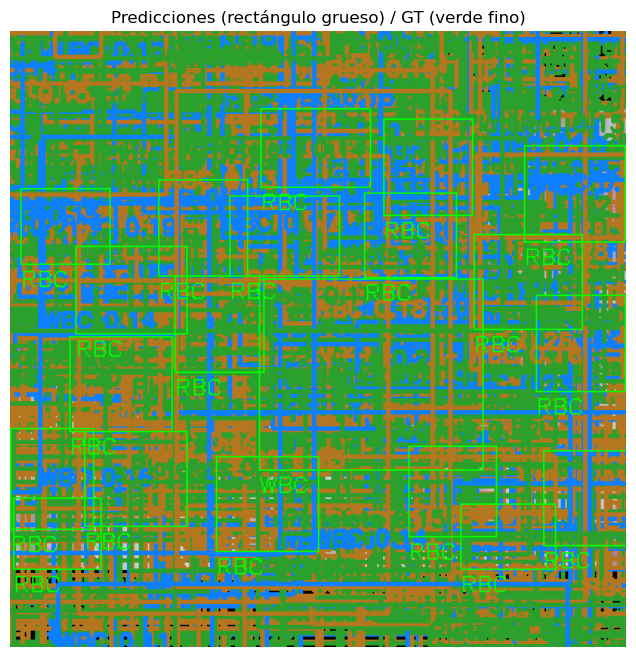

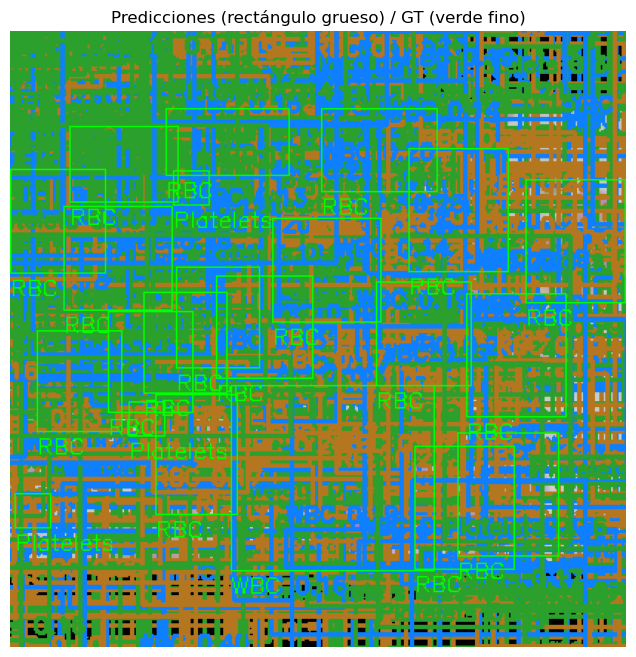

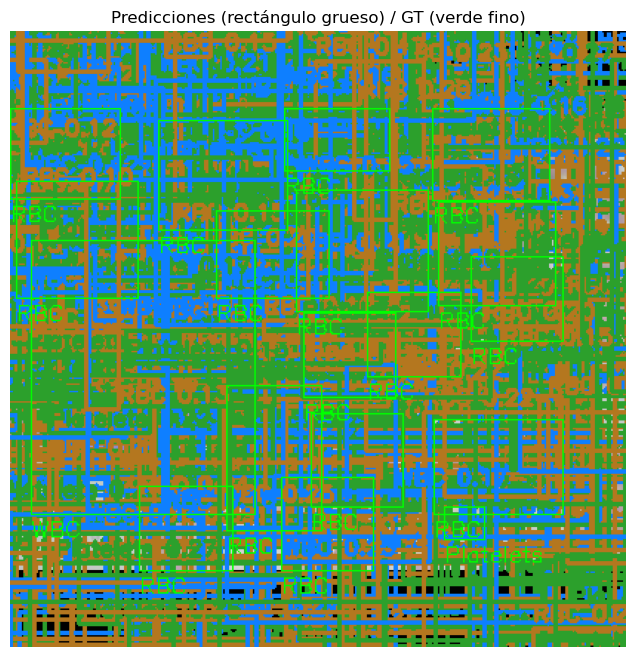

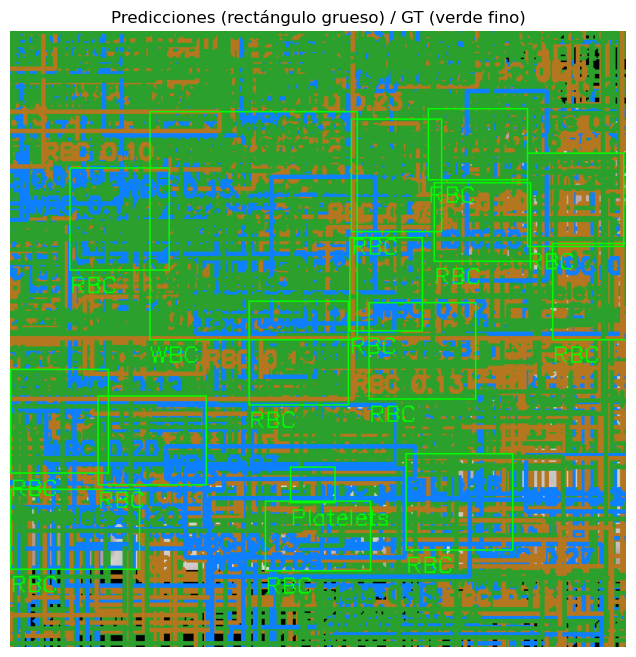

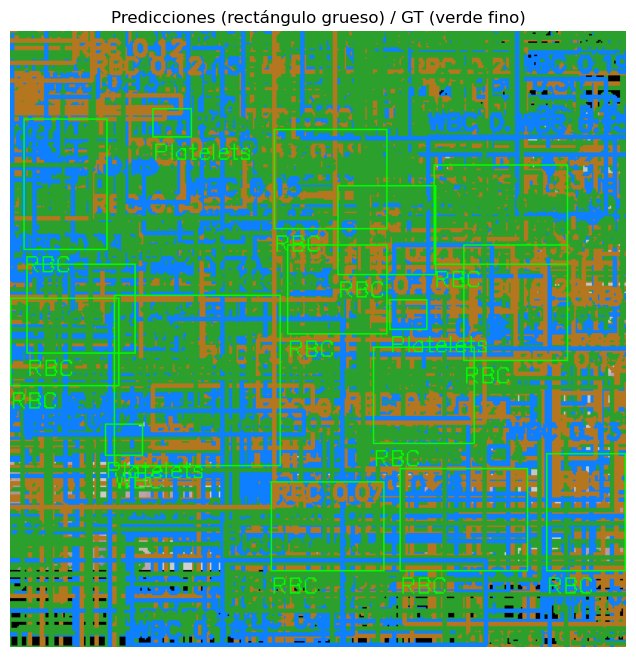

In [22]:
import cv2
import matplotlib.pyplot as plt

def show_yolo_predictions(
    model, dataloader, anchors, num_classes, class_names,
    device, img_size=416, conf_threshold=0.3, iou_threshold=0.5,
    max_images=10, show_gt=True
):
    """
    Visualiza las predicciones del modelo YOLOv3 sobre imágenes reales.
    - model: tu modelo
    - dataloader: DataLoader (test o val)
    - anchors, num_classes: como en tu pipeline
    - class_names: lista de strings de nombres de clase
    - device: cpu o cuda
    - img_size: tamaño de entrada del modelo
    - conf_threshold: umbral de confianza para mostrar predicciones
    - iou_threshold: NMS
    - max_images: máximo de imágenes a visualizar
    - show_gt: si True, dibuja también las GT
    """
    model.eval()
    cmap = plt.get_cmap('tab10')
    with torch.no_grad():
        shown = 0
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_boxes = yolo_decode_outputs(
                outputs, anchors, num_classes, img_size=img_size,
                conf_thres=conf_threshold, iou_thres=iou_threshold, device=device
            )
            for i in range(images.shape[0]):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                # Desnormaliza si usaste normalización estándar
                img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                img_np = (img_np * 255).clip(0,255).astype(np.uint8)
                img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                # Dibuja predicciones
                for pb in pred_boxes[i]:
                    class_id = int(pb[0])
                    cx, cy, w, h, conf = pb[1], pb[2], pb[3], pb[4], pb[5]
                    x1 = int((cx - w/2) * img_bgr.shape[1])
                    y1 = int((cy - h/2) * img_bgr.shape[0])
                    x2 = int((cx + w/2) * img_bgr.shape[1])
                    y2 = int((cy + h/2) * img_bgr.shape[0])
                    color = tuple([int(255*x) for x in cmap(class_id)[:3]])
                    cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 2)
                    label = f"{class_names[class_id]} {conf:.2f}"
                    cv2.putText(img_bgr, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Dibuja GT (opcional)
                if show_gt and len(targets[i]) > 0:
                    for gt in targets[i]:
                        class_id = int(gt[0].item())
                        cx, cy, w, h = gt[1:].tolist()
                        x1 = int((cx - w/2) * img_bgr.shape[1])
                        y1 = int((cy - h/2) * img_bgr.shape[0])
                        x2 = int((cx + w/2) * img_bgr.shape[1])
                        y2 = int((cy + h/2) * img_bgr.shape[0])
                        color = (0,255,0)  # Verde para GT (puedes cambiarlo)
                        cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 1)
                        cv2.putText(img_bgr, class_names[class_id], (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                # Muestra la imagen
                plt.figure(figsize=(8,8))
                plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
                plt.title('Predicciones (rectángulo grueso) / GT (verde fino)')
                plt.axis('off')
                plt.show()
                shown += 1
                if shown >= max_images:
                    return

# Ejemplo de uso:

class_names = ['RBC', 'WBC', 'Platelets']
show_yolo_predictions(
    model, test_loader, anchors=ANCHORS, num_classes=NUM_CLASSES,
    class_names=class_names, device=device, img_size=416,
    conf_threshold=0.3, iou_threshold=0.5, max_images=5, show_gt=True
)